In [66]:

import argparse
import os
import random
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.pyplot import imshow, imsave

# Set random seem for reproducibility
manualSeed = 1312
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

print(torchvision.__version__)

Random Seed:  1312
0.2.1


In [67]:
# This cell is only for Google Colaboratory
#from google.colab import drive
#drive.mount('/content/gdrive')
#
path1 = "train_images" # Fake generated images here
path2 = "gen"   # Generator parameters path
path3 = "dis"   # Discriminator parameters path

In [68]:
# Root directory for dataset
dataroot = "Art/Uusi_Kansio"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 100

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3 # with mnist 1, other 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
max_epoch = 100 # need more than 20 epochs for training generator

# Learning rate for optimizers
lr = 0.0005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Number of labels
num_labels = 4 # we will use 4, CIFAR and MNIST has 10

In [69]:
# Define which device you use for calculation. If you can use cuda, this will automatically use it. Otherwise cpu is automatically used.

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [5]:

#transform=torchvision.transforms.Compose([
 #                                torchvision.transforms.Resize(image_size),
  #                               torchvision.transforms.ToTensor(),
   #                              torchvision.transforms.Normalize(
    #                             (0.5,0.5,0.5), (0.5,0.5,0.5))])

#dataset =  torchvision.datasets.CIFAR10('/files/', train=True, download=True, transform = transform)

#data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

#real_batch = next(iter(data_loader))
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(DEVICE)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [86]:
dataroot = []
dataset = []
# Create new dataset from images
for i in range(1,num_labels + 1):
    dataset.append(dset.ImageFolder(root=F"./Dog_images/Label{i}",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])))

# Create labels for our dataset
# Labels are in i
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i].samples[j] = (dataset[i].samples[j][0],i)
        
# Combine all the datasets
newdataset = torch.utils.data.ConcatDataset(dataset)

50200


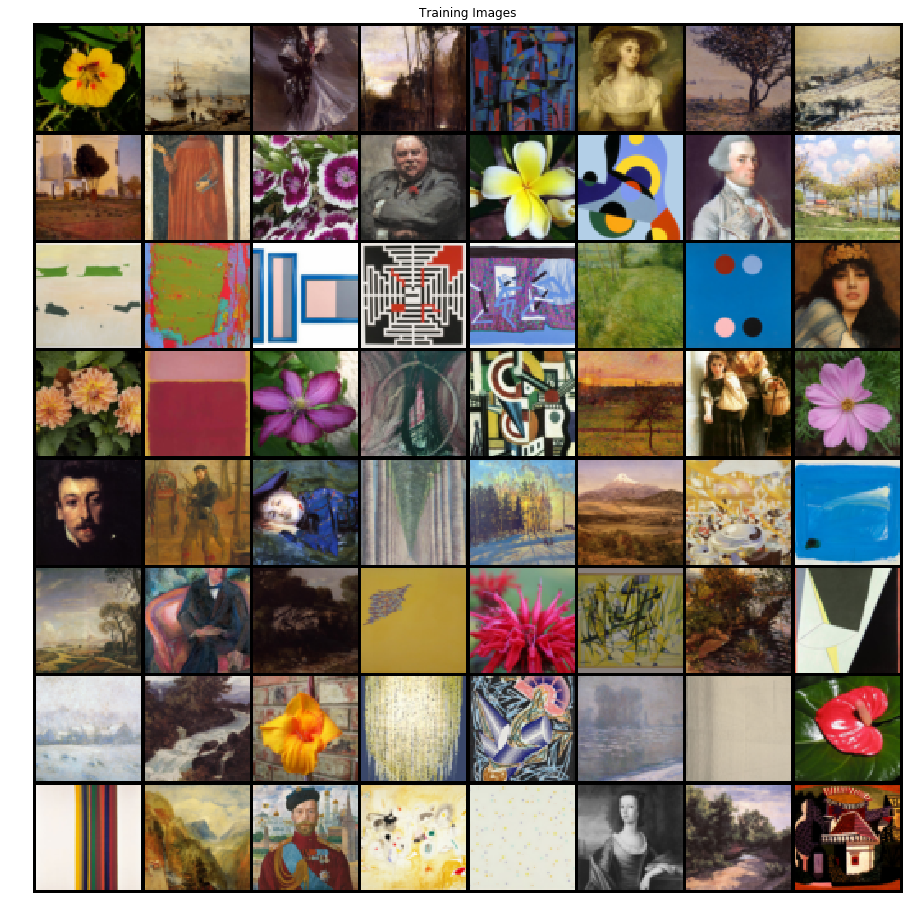

In [87]:
dataloader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                        shuffle=True, num_workers=workers)

# Decide which device we want to run on
#DEVICE = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch,labels = next(iter(dataloader))
plt.figure(figsize=(16,16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(DEVICE), padding=2, nrow = 10, normalize=True).cpu(),(1,2,0)))

print(len(dataloader.dataset))

In [88]:
def normal_init(m, mean=0., std=0.02):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        #m.bias.data.zero_()
print(len(dataloader.dataset))        

50200


In [89]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
        MUUTTUJAT PÄIN VITTUA, KORJATKAA GLOBAALISTA LOKAAlIKSI
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(nc, ndf,4,2,1,bias=False)
        
        # first parameter is number of classes, condition_size is the same as number of classes
        self.convlabel = nn.Conv2d(condition_size, ndf,4,2,1,bias=False)
        self.conv2 = nn.Conv2d(ndf * 2,ndf * 4, 4, 2, 1, bias = False)
        self.bn1 = nn.BatchNorm2d(ndf * 4)
        self.conv3 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(ndf * 8)
        self.conv4 = nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(ndf * 16)
        self.conv5 = nn.Conv2d(ndf * 16, 1, 4, 1, 0, bias=False)

        self.act = nn.LeakyReLU(0.2,inplace=True)
        self.out = nn.Sigmoid()
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    
    def forward(self, x, y=None):
        
        x = self.act(self.conv1(x))
        y = self.act(self.convlabel(y))
        x = torch.cat([x,y],1)
        x = self.act(self.bn1(self.conv2(x)))
        x = self.act(self.bn2(self.conv3(x)))
        x = self.act(self.bn3(self.conv4(x)))
        x = self.conv5(x)
        return self.out(x)

In [90]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size = 100, condition_size=10):
        super(Generator, self).__init__()
        
        self.conv1 = nn.ConvTranspose2d(input_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1 = nn.BatchNorm2d(ngf*8)
        
        
        # first parameter is number of classes
        self.convlabel = nn.ConvTranspose2d(condition_size, ngf * 8, 4, 1, 0,bias=False)
        self.bn1_1 = nn.BatchNorm2d(ngf * 8)
        
        self.act = nn.ReLU()
        
        self.conv2 = nn.ConvTranspose2d(ngf * 16,ngf * 8, 4, 2, 1, bias = False)
        self.bn2 = nn.BatchNorm2d(ngf * 8)

        self.conv3 = nn.ConvTranspose2d(ngf * 8,ngf * 4, 4, 2, 1, bias = False)
        self.bn3 = nn.BatchNorm2d(ngf * 4)
        
        self.conv4 = nn.ConvTranspose2d(ngf * 4,ngf * 2, 4, 2, 1, bias = False)
        self.bn4 = nn.BatchNorm2d(ngf * 2)
        
        self.conv5 = nn.ConvTranspose2d(ngf*2, nc, 4, 2, 1, bias = False)
        self.out = nn.Tanh()
        self.weight_init(mean = 0., std = 0.02)
    
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x, y):
        
        x = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn1_1(self.convlabel(y)))
        x = torch.cat([x,y],1)
        x = self.act(self.bn2(self.conv2(x)))
        x = self.act(self.bn3(self.conv3(x)))
        x = self.act(self.bn4(self.conv4(x)))
        x = self.conv5(x)
        
        return self.out(x)

In [91]:
D = Discriminator(condition_size = num_labels).to(DEVICE)
G = Generator(condition_size=num_labels).to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

# Initialize discriminator and Generator weights
#D.apply(weight_init)
#G.apply(weight_init)


# Setup Adam optimizers for both G and D
D_opt = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

print(ngf*8)

512


In [92]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn((batch_size, 100, 1, 1))
fixed_noise = Variable(fixed_noise.to(DEVICE))




In [93]:
# Initialize stuff before training
step = 0
n_critic = 1 # for training more k steps about Discriminator
n_noise = 100

In [94]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

[0/100][0]	Loss_D: 1.6926	Loss_G: 15.0028	D(x): 0.7500	D(G(z)): 0.7348 / 0.0000
[0/100][20]	Loss_D: 0.9426	Loss_G: 1.2272	D(x): 0.9106	D(G(z)): 0.4970 / 0.3537
[0/100][40]	Loss_D: 2.5460	Loss_G: 6.1986	D(x): 0.1447	D(G(z)): 0.0015 / 0.0053
[0/100][60]	Loss_D: 1.1687	Loss_G: 7.1089	D(x): 0.9390	D(G(z)): 0.6325 / 0.0025
[0/100][80]	Loss_D: 1.5495	Loss_G: 3.9152	D(x): 0.7161	D(G(z)): 0.5884 / 0.0488
[0/100][100]	Loss_D: 1.2738	Loss_G: 1.9778	D(x): 0.3933	D(G(z)): 0.1026 / 0.2300
[0/100][120]	Loss_D: 0.9667	Loss_G: 2.9917	D(x): 0.7840	D(G(z)): 0.3644 / 0.0999
[0/100][140]	Loss_D: 1.3564	Loss_G: 1.0469	D(x): 0.3090	D(G(z)): 0.0346 / 0.4215
[0/100][160]	Loss_D: 0.4712	Loss_G: 2.6239	D(x): 0.6890	D(G(z)): 0.0434 / 0.0983
[0/100][180]	Loss_D: 0.6172	Loss_G: 1.2301	D(x): 0.8550	D(G(z)): 0.3386 / 0.3445
[0/100][200]	Loss_D: 1.4706	Loss_G: 2.4762	D(x): 0.9089	D(G(z)): 0.7049 / 0.1026
[0/100][220]	Loss_D: 0.5981	Loss_G: 0.3293	D(x): 0.8418	D(G(z)): 0.3194 / 0.7309
[0/100][240]	Loss_D: 1.1417	Loss_

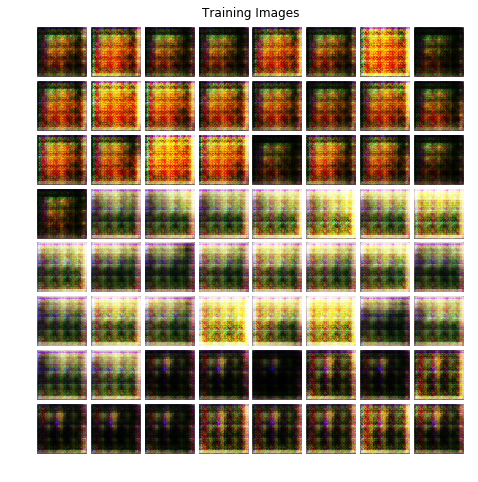

[1/100][520]	Loss_D: 0.3219	Loss_G: 3.8657	D(x): 0.8599	D(G(z)): 0.1517 / 0.0246
[1/100][540]	Loss_D: 0.7391	Loss_G: 2.7071	D(x): 0.9930	D(G(z)): 0.5165 / 0.0690
[1/100][560]	Loss_D: 0.7521	Loss_G: 1.0824	D(x): 0.9361	D(G(z)): 0.4740 / 0.3570
[1/100][580]	Loss_D: 0.5185	Loss_G: 0.3221	D(x): 0.6265	D(G(z)): 0.0472 / 0.7283
[1/100][600]	Loss_D: 0.3253	Loss_G: 0.7814	D(x): 0.8669	D(G(z)): 0.1595 / 0.4871
[1/100][620]	Loss_D: 1.9415	Loss_G: 0.7586	D(x): 0.1498	D(G(z)): 0.0178 / 0.4948
[1/100][640]	Loss_D: 0.9274	Loss_G: 2.0653	D(x): 0.9769	D(G(z)): 0.5845 / 0.1531
[1/100][660]	Loss_D: 0.2952	Loss_G: 1.2415	D(x): 0.9868	D(G(z)): 0.2381 / 0.3961
[1/100][680]	Loss_D: 0.3779	Loss_G: 5.4959	D(x): 0.9281	D(G(z)): 0.2525 / 0.0047
[1/100][700]	Loss_D: 0.2220	Loss_G: 6.3808	D(x): 0.8355	D(G(z)): 0.0259 / 0.0019
[1/100][720]	Loss_D: 0.8030	Loss_G: 0.3288	D(x): 0.5074	D(G(z)): 0.0931 / 0.7218
[1/100][740]	Loss_D: 1.5814	Loss_G: 0.9194	D(x): 0.2566	D(G(z)): 0.0714 / 0.4111
[1/100][760]	Loss_D: 0.1106	

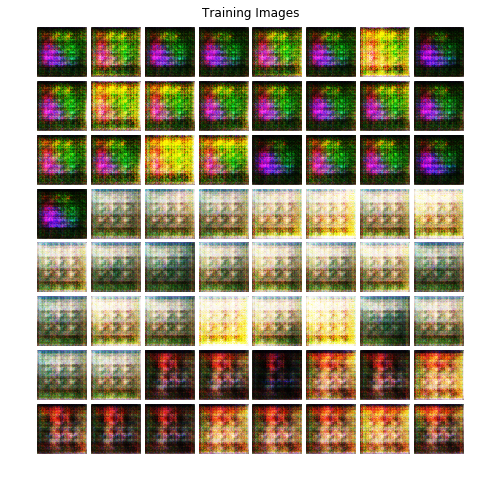

[2/100][1020]	Loss_D: 0.2372	Loss_G: 2.9973	D(x): 0.8242	D(G(z)): 0.0211 / 0.0522
[2/100][1040]	Loss_D: 2.2138	Loss_G: 0.2453	D(x): 0.1350	D(G(z)): 0.0058 / 0.7855
[2/100][1060]	Loss_D: 0.0439	Loss_G: 5.2238	D(x): 0.9621	D(G(z)): 0.0050 / 0.0119
[2/100][1080]	Loss_D: 0.0167	Loss_G: 0.1092	D(x): 0.9993	D(G(z)): 0.0159 / 0.8970
[2/100][1100]	Loss_D: 4.3394	Loss_G: 2.3078	D(x): 0.0137	D(G(z)): 0.0156 / 0.1353
[2/100][1120]	Loss_D: 1.0773	Loss_G: 0.5714	D(x): 0.8399	D(G(z)): 0.5923 / 0.5670
[2/100][1140]	Loss_D: 0.3723	Loss_G: 7.3427	D(x): 0.8940	D(G(z)): 0.2014 / 0.0017
[2/100][1160]	Loss_D: 0.7353	Loss_G: 3.5156	D(x): 0.8601	D(G(z)): 0.4404 / 0.0307
[2/100][1180]	Loss_D: 0.0549	Loss_G: 2.5638	D(x): 0.9783	D(G(z)): 0.0324 / 0.0828
[2/100][1200]	Loss_D: 1.4005	Loss_G: 4.2259	D(x): 0.8048	D(G(z)): 0.6515 / 0.0187
[2/100][1220]	Loss_D: 0.7115	Loss_G: 1.1954	D(x): 0.5182	D(G(z)): 0.0503 / 0.3067
[2/100][1240]	Loss_D: 1.1465	Loss_G: 1.9892	D(x): 0.8413	D(G(z)): 0.5640 / 0.2040
[2/100][1260]	Lo

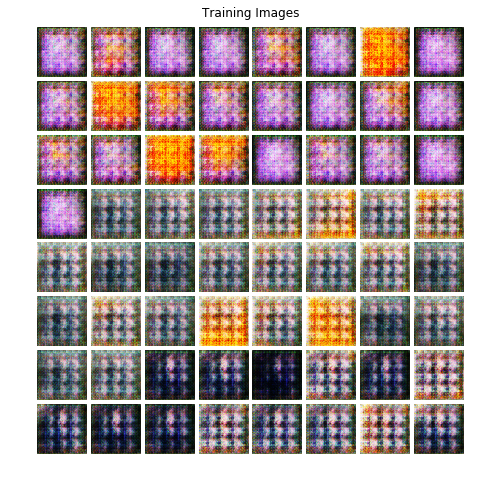

[3/100][1520]	Loss_D: 1.4099	Loss_G: 5.1016	D(x): 0.2766	D(G(z)): 0.0216 / 0.0091
[3/100][1540]	Loss_D: 0.1338	Loss_G: 1.7315	D(x): 0.9301	D(G(z)): 0.0564 / 0.1934
[3/100][1560]	Loss_D: 0.3841	Loss_G: 0.6598	D(x): 0.9521	D(G(z)): 0.2778 / 0.5219
[3/100][1580]	Loss_D: 0.1582	Loss_G: 3.8315	D(x): 0.8554	D(G(z)): 0.0016 / 0.0218
[3/100][1600]	Loss_D: 1.9997	Loss_G: 1.7190	D(x): 0.1519	D(G(z)): 0.0006 / 0.2113
[3/100][1620]	Loss_D: 0.6733	Loss_G: 3.3804	D(x): 0.5801	D(G(z)): 0.0990 / 0.0377
[3/100][1640]	Loss_D: 1.5585	Loss_G: 3.8109	D(x): 0.3664	D(G(z)): 0.3484 / 0.0358
[3/100][1660]	Loss_D: 0.5244	Loss_G: 0.9623	D(x): 0.6071	D(G(z)): 0.0039 / 0.3869
[3/100][1680]	Loss_D: 1.2137	Loss_G: 1.9414	D(x): 0.9982	D(G(z)): 0.6915 / 0.1475
[3/100][1700]	Loss_D: 2.2836	Loss_G: 1.7744	D(x): 0.9179	D(G(z)): 0.8626 / 0.1732
[3/100][1720]	Loss_D: 0.0442	Loss_G: 3.9892	D(x): 0.9706	D(G(z)): 0.0141 / 0.0349
[3/100][1740]	Loss_D: 0.0832	Loss_G: 1.8252	D(x): 0.9452	D(G(z)): 0.0256 / 0.1792
[3/100][1760]	Lo

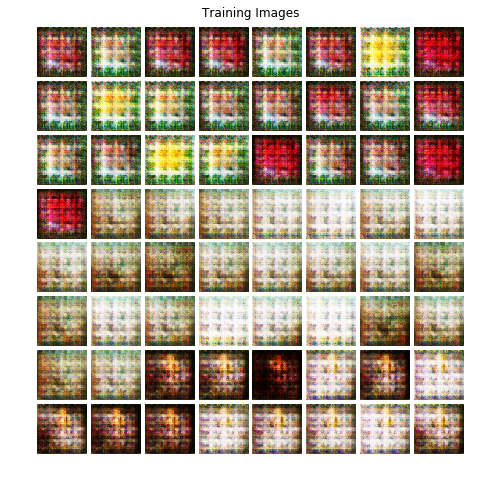

[4/100][2020]	Loss_D: 1.1742	Loss_G: 3.0040	D(x): 0.3471	D(G(z)): 0.0585 / 0.0570
[4/100][2040]	Loss_D: 0.4630	Loss_G: 1.5949	D(x): 0.9795	D(G(z)): 0.3564 / 0.2052
[4/100][2060]	Loss_D: 0.4265	Loss_G: 4.0072	D(x): 0.8284	D(G(z)): 0.2103 / 0.0194
[4/100][2080]	Loss_D: 1.2741	Loss_G: 0.0553	D(x): 0.2831	D(G(z)): 0.0067 / 0.9463
[4/100][2100]	Loss_D: 0.4857	Loss_G: 0.9057	D(x): 0.9617	D(G(z)): 0.3493 / 0.4079


In [ ]:
# Training loop
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create arrays for Generator and Discriminator losses
G_losses = []
D_losses = []
img_list = []

fixed_y = torch.zeros(num_labels, 1)
y_label = torch.zeros(batch_size, num_labels)

# Creates onehot array, that is diagonal matrix in tensor from.
onehot = torch.zeros(num_labels, num_labels)
onehot = onehot.scatter_(1, torch.LongTensor([range(num_labels)]).view(num_labels,1), 1).view(num_labels, num_labels, 1, 1)

# Creates fill that makes image size layer with ones for each label
fill = torch.zeros([num_labels, num_labels, image_size, image_size]).to(DEVICE)
for i in range(num_labels):
    fill[i, i, :, :] = 1



# Fixed Y labels for evaluation
y_0 = torch.full((batch_size//num_labels, 1), 0).type(torch.LongTensor).squeeze()
y_fixed_labels = torch.zeros(batch_size, num_labels)

for i in range(1,num_labels):
    desired_label = i
    y_fixed = torch.full((batch_size//num_labels, 1), desired_label).type(torch.LongTensor).squeeze()

    y_0 = torch.cat((y_0, y_fixed), 0)

y_fixed_labels = onehot[y_0]
y_fixed_labels= Variable(y_fixed_labels.cuda())


for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(dataloader):

        # Training Discriminator
        D.zero_grad()
        # Use print(labels.shape) to check how large batch size should be
        #print(labels.shape)
        
        
        y_fill = fill[labels]
        
        x = images.to(DEVICE)
        y = y_fill
        x_outputs = D(x, y)
        x_outputs = x_outputs.view(-1,1)
        D_x = x_outputs.mean().item() # D(x|c) for real data
        D_x_loss = criterion(x_outputs, D_labels)
        
        # Fake data:
        
        z = torch.randn((batch_size, 100, 1, 1))
        y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
        y_label = onehot[y_rand]
        y_fill = fill[y_rand]
        z = Variable(z.to(DEVICE))
        y_label = Variable(y_label.to(DEVICE))
        y_fill =  Variable(y_fill.to(DEVICE))
        
        fake_images = G(z, y_label)
        
        fake_outputs = D(fake_images, y_fill)
        fake_outputs = fake_outputs.view(-1,1)
        D_g_z1 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
        D_z_loss = criterion(fake_outputs, D_fakes)
         
        D_loss = D_x_loss + D_z_loss
        
        
        D_loss.backward()
        D_opt.step()
        
        if step % n_critic == 0:
            # Training Generator
            G.zero_grad()
            z = torch.randn((batch_size, 100, 1, 1))
            y_rand = (torch.rand(batch_size, 1) * num_labels).type(torch.LongTensor).squeeze()
            y_label = onehot[y_rand]
            y_fill = fill[y_rand]
            z = Variable(z.to(DEVICE))
            y_label = Variable(y_label.to(DEVICE))
            y_fill =  Variable(y_fill.to(DEVICE))
            
            fake_images = G(z,y_label)
            fake_outputs = D(fake_images, y_fill)
            D_g_z2 = fake_outputs.mean().item() # D(G(z|c)|c) for fake data
            fake_outputs = fake_outputs.view(-1,1)
            G_loss = criterion(fake_outputs, D_labels)
            
            
            G_loss.backward()
            G_opt.step()       
        if step % 20 == 0:
            #print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {},  D(x): {}   D(G(z)): {} / {}'.format(epoch, max_epoch, 
            #                                        step, D_loss.item(), G_loss.item(),D_x,D_g_z1,D_g_z2))
            print('[%d/%d][%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, max_epoch, step,
                     D_loss.item(), G_loss.item(), D_x, D_g_z1, D_g_z2))
            
            # Output training stats
        

            # Save Losses for plotting later
            G_losses.append(G_loss.item())
            D_losses.append(D_loss.item())
            
        step += 1
        
    if (epoch % 1 == 0):
        print("Figure number: ", epoch+1)
        # generation to image
        G.eval()

        # Create labels from 0 to 9 (tensor is 100 long)
       
        # save image
        
        #torch.save(netG.state_dict(), os.path.join(path2, 'G--{}.ckpt'.format(epoch+1)))
        #torch.save(netD.state_dict(), os.path.join(path3, 'D--{}.ckpt'.format(epoch+1)))
        with torch.no_grad():
            fake_images = G(fixed_noise,y_fixed_labels).detach().cpu()
        
        plt.figure(figsize=(8,8))
        plt.axis("off")
        plt.title("Training Images")
        plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE), padding=5,pad_value = 1, nrow = 10, normalize=True).cpu(),(1,2,0)))
        plt.show()

        
        img_list.append(vutils.make_grid(fake_images, padding=2, nrow = 10, normalize=True))
        vutils.save_image((fake_images.data), os.path.join(path1, 'fake_images-{}.png'.format(epoch+1)), nrow = 10, normalize=True)
        
        G.train()   

In [ ]:
# Plot losses

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# generation to image
G.eval()

# put here the desired label you want to be seen
desired_label = 0

y_rand = torch.full((batch_size, 1), desired_label).type(torch.LongTensor).squeeze()
y_label = onehot[y_rand]
#y_label = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(10,1), 1).view(10, 10, 1, 1)
z = Variable(z.cuda())
y_label = Variable(y_label.cuda())


# Generate images using fixed noise and specific labels. For example "generate fake landscape images"
with torch.no_grad():
    fake_images = G(fixed_noise,y_label).detach().cpu()


    

# Plot figures of specific labels    
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake_images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))


# Plot each image separately.

#print(fake_images[0][0].shape)
#for i in range(20):
 #   plt.imshow(fake_images[i][0])
  #  plt.show()

In [ ]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [ ]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_dc.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_dc.pth.tar')

In [ ]:
steps = 0
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
for idx, (images, labels) in enumerate(dataloader):
    path, target = dataloader.dataset[0]
#print(path)
#print(target)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(vutils.make_grid(images.to(DEVICE), padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))
    if steps >= 220:
        #plt.figure(figsize=(15,15))
        #plt.imshow(np.transpose(vutils.make_grid(images.to(DEVICE)[:64], padding=5,pad_value = 1, normalize=True).cpu(),(1,2,0)))
        #plt.show()
        print(jauzaa)
    if (steps % 10 ==0):
        print(steps)
    steps += 1

In [65]:

# This is used to check if there are corrupted image files.

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


# instantiate the dataset and dataloader
transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize(image_size),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (0.5,0.5,0.5), (0.5,0.5,0.5))])

data_dir = F"./Dog_images/Label4/"
dataset = ImageFolderWithPaths(data_dir, transform = transform)
print(dataset)# our custom dataset
dataloader = torch.utils.data.DataLoader(dataset)

# iterate over data
for inputs, labels, paths in dataloader:
    # use the above variables freely
    print(paths)

Dataset ImageFolderWithPaths
    Number of datapoints: 13398
    Root Location: ./Dog_images/Label4/
    Transforms (if any): Compose(
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None
('./Dog_images/Label4/abstract\\abstract (1).jpg',)
('./Dog_images/Label4/abstract\\abstract (10).jpg',)
('./Dog_images/Label4/abstract\\abstract (100).jpg',)
('./Dog_images/Label4/abstract\\abstract (1000).jpg',)
('./Dog_images/Label4/abstract\\abstract (10000).jpg',)
('./Dog_images/Label4/abstract\\abstract (10001).jpg',)
('./Dog_images/Label4/abstract\\abstract (10002).jpg',)
('./Dog_images/Label4/abstract\\abstract (10003).jpg',)
('./Dog_images/Label4/abstract\\abstract (10004).jpg',)
('./Dog_images/Label4/abstract\\abstract (10005).jpg',)
('./Dog_images/Label4/abstract\\abstract (10006).j

('./Dog_images/Label4/abstract\\abstract (10128).jpg',)
('./Dog_images/Label4/abstract\\abstract (10129).jpg',)
('./Dog_images/Label4/abstract\\abstract (1013).jpg',)
('./Dog_images/Label4/abstract\\abstract (10130).jpg',)
('./Dog_images/Label4/abstract\\abstract (10131).jpg',)
('./Dog_images/Label4/abstract\\abstract (10132).jpg',)
('./Dog_images/Label4/abstract\\abstract (10133).jpg',)
('./Dog_images/Label4/abstract\\abstract (10134).jpg',)
('./Dog_images/Label4/abstract\\abstract (10135).jpg',)
('./Dog_images/Label4/abstract\\abstract (10136).jpg',)
('./Dog_images/Label4/abstract\\abstract (10137).jpg',)
('./Dog_images/Label4/abstract\\abstract (10138).jpg',)
('./Dog_images/Label4/abstract\\abstract (10139).jpg',)
('./Dog_images/Label4/abstract\\abstract (1014).jpg',)
('./Dog_images/Label4/abstract\\abstract (10140).jpg',)
('./Dog_images/Label4/abstract\\abstract (10141).jpg',)
('./Dog_images/Label4/abstract\\abstract (10142).jpg',)
('./Dog_images/Label4/abstract\\abstract (10143).j

('./Dog_images/Label4/abstract\\abstract (10264).jpg',)
('./Dog_images/Label4/abstract\\abstract (10265).jpg',)
('./Dog_images/Label4/abstract\\abstract (10266).jpg',)
('./Dog_images/Label4/abstract\\abstract (10267).jpg',)
('./Dog_images/Label4/abstract\\abstract (10268).jpg',)
('./Dog_images/Label4/abstract\\abstract (10269).jpg',)
('./Dog_images/Label4/abstract\\abstract (1027).jpg',)
('./Dog_images/Label4/abstract\\abstract (10270).jpg',)
('./Dog_images/Label4/abstract\\abstract (10271).jpg',)
('./Dog_images/Label4/abstract\\abstract (10272).jpg',)
('./Dog_images/Label4/abstract\\abstract (10273).jpg',)
('./Dog_images/Label4/abstract\\abstract (10274).jpg',)
('./Dog_images/Label4/abstract\\abstract (10275).jpg',)
('./Dog_images/Label4/abstract\\abstract (10276).jpg',)
('./Dog_images/Label4/abstract\\abstract (10277).jpg',)
('./Dog_images/Label4/abstract\\abstract (10278).jpg',)
('./Dog_images/Label4/abstract\\abstract (10279).jpg',)
('./Dog_images/Label4/abstract\\abstract (1028).j

('./Dog_images/Label4/abstract\\abstract (10403).jpg',)
('./Dog_images/Label4/abstract\\abstract (10404).jpg',)
('./Dog_images/Label4/abstract\\abstract (10405).jpg',)
('./Dog_images/Label4/abstract\\abstract (10406).jpg',)
('./Dog_images/Label4/abstract\\abstract (10407).jpg',)
('./Dog_images/Label4/abstract\\abstract (10408).jpg',)
('./Dog_images/Label4/abstract\\abstract (10409).jpg',)
('./Dog_images/Label4/abstract\\abstract (1041).jpg',)
('./Dog_images/Label4/abstract\\abstract (10410).jpg',)
('./Dog_images/Label4/abstract\\abstract (10411).jpg',)
('./Dog_images/Label4/abstract\\abstract (10412).jpg',)
('./Dog_images/Label4/abstract\\abstract (10413).jpg',)
('./Dog_images/Label4/abstract\\abstract (10414).jpg',)
('./Dog_images/Label4/abstract\\abstract (10415).jpg',)
('./Dog_images/Label4/abstract\\abstract (10416).jpg',)
('./Dog_images/Label4/abstract\\abstract (10417).jpg',)
('./Dog_images/Label4/abstract\\abstract (10418).jpg',)
('./Dog_images/Label4/abstract\\abstract (10419).

('./Dog_images/Label4/abstract\\abstract (10552).jpg',)
('./Dog_images/Label4/abstract\\abstract (10553).jpg',)
('./Dog_images/Label4/abstract\\abstract (10554).jpg',)
('./Dog_images/Label4/abstract\\abstract (10555).jpg',)
('./Dog_images/Label4/abstract\\abstract (10556).jpg',)
('./Dog_images/Label4/abstract\\abstract (10557).jpg',)
('./Dog_images/Label4/abstract\\abstract (10558).jpg',)
('./Dog_images/Label4/abstract\\abstract (10559).jpg',)
('./Dog_images/Label4/abstract\\abstract (1056).jpg',)
('./Dog_images/Label4/abstract\\abstract (10560).jpg',)
('./Dog_images/Label4/abstract\\abstract (10561).jpg',)
('./Dog_images/Label4/abstract\\abstract (10562).jpg',)
('./Dog_images/Label4/abstract\\abstract (10563).jpg',)
('./Dog_images/Label4/abstract\\abstract (10564).jpg',)
('./Dog_images/Label4/abstract\\abstract (10565).jpg',)
('./Dog_images/Label4/abstract\\abstract (10566).jpg',)
('./Dog_images/Label4/abstract\\abstract (10567).jpg',)
('./Dog_images/Label4/abstract\\abstract (10568).

('./Dog_images/Label4/abstract\\abstract (10699).jpg',)
('./Dog_images/Label4/abstract\\abstract (107).jpg',)
('./Dog_images/Label4/abstract\\abstract (1070).jpg',)
('./Dog_images/Label4/abstract\\abstract (10700).jpg',)
('./Dog_images/Label4/abstract\\abstract (10701).jpg',)
('./Dog_images/Label4/abstract\\abstract (10702).jpg',)
('./Dog_images/Label4/abstract\\abstract (10703).jpg',)
('./Dog_images/Label4/abstract\\abstract (10704).jpg',)
('./Dog_images/Label4/abstract\\abstract (10705).jpg',)
('./Dog_images/Label4/abstract\\abstract (10706).jpg',)
('./Dog_images/Label4/abstract\\abstract (10707).jpg',)
('./Dog_images/Label4/abstract\\abstract (10708).jpg',)
('./Dog_images/Label4/abstract\\abstract (10709).jpg',)
('./Dog_images/Label4/abstract\\abstract (1071).jpg',)
('./Dog_images/Label4/abstract\\abstract (10710).jpg',)
('./Dog_images/Label4/abstract\\abstract (10711).jpg',)
('./Dog_images/Label4/abstract\\abstract (10712).jpg',)
('./Dog_images/Label4/abstract\\abstract (10713).jpg

('./Dog_images/Label4/abstract\\abstract (10834).jpg',)
('./Dog_images/Label4/abstract\\abstract (10835).jpg',)
('./Dog_images/Label4/abstract\\abstract (10836).jpg',)
('./Dog_images/Label4/abstract\\abstract (10837).jpg',)
('./Dog_images/Label4/abstract\\abstract (10838).jpg',)
('./Dog_images/Label4/abstract\\abstract (10839).jpg',)
('./Dog_images/Label4/abstract\\abstract (1084).jpg',)
('./Dog_images/Label4/abstract\\abstract (10840).jpg',)
('./Dog_images/Label4/abstract\\abstract (10841).jpg',)
('./Dog_images/Label4/abstract\\abstract (10842).jpg',)
('./Dog_images/Label4/abstract\\abstract (10843).jpg',)
('./Dog_images/Label4/abstract\\abstract (10844).jpg',)
('./Dog_images/Label4/abstract\\abstract (10845).jpg',)
('./Dog_images/Label4/abstract\\abstract (10846).jpg',)
('./Dog_images/Label4/abstract\\abstract (10847).jpg',)
('./Dog_images/Label4/abstract\\abstract (10848).jpg',)
('./Dog_images/Label4/abstract\\abstract (10849).jpg',)
('./Dog_images/Label4/abstract\\abstract (1085).j

('./Dog_images/Label4/abstract\\abstract (10968).jpg',)
('./Dog_images/Label4/abstract\\abstract (10969).jpg',)
('./Dog_images/Label4/abstract\\abstract (1097).jpg',)
('./Dog_images/Label4/abstract\\abstract (10970).jpg',)
('./Dog_images/Label4/abstract\\abstract (10971).jpg',)
('./Dog_images/Label4/abstract\\abstract (10972).jpg',)
('./Dog_images/Label4/abstract\\abstract (10973).jpg',)
('./Dog_images/Label4/abstract\\abstract (10974).jpg',)
('./Dog_images/Label4/abstract\\abstract (10975).jpg',)
('./Dog_images/Label4/abstract\\abstract (10976).jpg',)
('./Dog_images/Label4/abstract\\abstract (10977).jpg',)
('./Dog_images/Label4/abstract\\abstract (10978).jpg',)
('./Dog_images/Label4/abstract\\abstract (10979).jpg',)
('./Dog_images/Label4/abstract\\abstract (1098).jpg',)
('./Dog_images/Label4/abstract\\abstract (10980).jpg',)
('./Dog_images/Label4/abstract\\abstract (10981).jpg',)
('./Dog_images/Label4/abstract\\abstract (10982).jpg',)
('./Dog_images/Label4/abstract\\abstract (10983).j

('./Dog_images/Label4/abstract\\abstract (11112).jpg',)
('./Dog_images/Label4/abstract\\abstract (11113).jpg',)
('./Dog_images/Label4/abstract\\abstract (11114).jpg',)
('./Dog_images/Label4/abstract\\abstract (11115).jpg',)
('./Dog_images/Label4/abstract\\abstract (11116).jpg',)
('./Dog_images/Label4/abstract\\abstract (11117).jpg',)
('./Dog_images/Label4/abstract\\abstract (11118).jpg',)
('./Dog_images/Label4/abstract\\abstract (11119).jpg',)
('./Dog_images/Label4/abstract\\abstract (1112).jpg',)
('./Dog_images/Label4/abstract\\abstract (11120).jpg',)
('./Dog_images/Label4/abstract\\abstract (11121).jpg',)
('./Dog_images/Label4/abstract\\abstract (11122).jpg',)
('./Dog_images/Label4/abstract\\abstract (11123).jpg',)
('./Dog_images/Label4/abstract\\abstract (11124).jpg',)
('./Dog_images/Label4/abstract\\abstract (11125).jpg',)
('./Dog_images/Label4/abstract\\abstract (11126).jpg',)
('./Dog_images/Label4/abstract\\abstract (11127).jpg',)
('./Dog_images/Label4/abstract\\abstract (11128).

('./Dog_images/Label4/abstract\\abstract (11249).jpg',)
('./Dog_images/Label4/abstract\\abstract (1125).jpg',)
('./Dog_images/Label4/abstract\\abstract (11250).jpg',)
('./Dog_images/Label4/abstract\\abstract (11251).jpg',)
('./Dog_images/Label4/abstract\\abstract (11252).jpg',)
('./Dog_images/Label4/abstract\\abstract (11253).jpg',)
('./Dog_images/Label4/abstract\\abstract (11254).jpg',)
('./Dog_images/Label4/abstract\\abstract (11255).jpg',)
('./Dog_images/Label4/abstract\\abstract (11256).jpg',)
('./Dog_images/Label4/abstract\\abstract (11257).jpg',)
('./Dog_images/Label4/abstract\\abstract (11258).jpg',)
('./Dog_images/Label4/abstract\\abstract (11259).jpg',)
('./Dog_images/Label4/abstract\\abstract (1126).jpg',)
('./Dog_images/Label4/abstract\\abstract (11260).jpg',)
('./Dog_images/Label4/abstract\\abstract (11261).jpg',)
('./Dog_images/Label4/abstract\\abstract (11262).jpg',)
('./Dog_images/Label4/abstract\\abstract (11263).jpg',)
('./Dog_images/Label4/abstract\\abstract (11264).j

('./Dog_images/Label4/abstract\\abstract (11381).jpg',)
('./Dog_images/Label4/abstract\\abstract (11382).jpg',)
('./Dog_images/Label4/abstract\\abstract (11383).jpg',)
('./Dog_images/Label4/abstract\\abstract (11384).jpg',)
('./Dog_images/Label4/abstract\\abstract (11385).jpg',)
('./Dog_images/Label4/abstract\\abstract (11386).jpg',)
('./Dog_images/Label4/abstract\\abstract (11387).jpg',)
('./Dog_images/Label4/abstract\\abstract (11388).jpg',)
('./Dog_images/Label4/abstract\\abstract (11389).jpg',)
('./Dog_images/Label4/abstract\\abstract (1139).jpg',)
('./Dog_images/Label4/abstract\\abstract (11390).jpg',)
('./Dog_images/Label4/abstract\\abstract (11391).jpg',)
('./Dog_images/Label4/abstract\\abstract (11392).jpg',)
('./Dog_images/Label4/abstract\\abstract (11393).jpg',)
('./Dog_images/Label4/abstract\\abstract (11394).jpg',)
('./Dog_images/Label4/abstract\\abstract (11395).jpg',)
('./Dog_images/Label4/abstract\\abstract (11396).jpg',)
('./Dog_images/Label4/abstract\\abstract (11397).

('./Dog_images/Label4/abstract\\abstract (11520).jpg',)
('./Dog_images/Label4/abstract\\abstract (11521).jpg',)
('./Dog_images/Label4/abstract\\abstract (11522).jpg',)
('./Dog_images/Label4/abstract\\abstract (11523).jpg',)
('./Dog_images/Label4/abstract\\abstract (11524).jpg',)
('./Dog_images/Label4/abstract\\abstract (11525).jpg',)
('./Dog_images/Label4/abstract\\abstract (11526).jpg',)
('./Dog_images/Label4/abstract\\abstract (11527).jpg',)
('./Dog_images/Label4/abstract\\abstract (11528).jpg',)
('./Dog_images/Label4/abstract\\abstract (11529).jpg',)
('./Dog_images/Label4/abstract\\abstract (1153).jpg',)
('./Dog_images/Label4/abstract\\abstract (11530).jpg',)
('./Dog_images/Label4/abstract\\abstract (11531).jpg',)
('./Dog_images/Label4/abstract\\abstract (11532).jpg',)
('./Dog_images/Label4/abstract\\abstract (11533).jpg',)
('./Dog_images/Label4/abstract\\abstract (11534).jpg',)
('./Dog_images/Label4/abstract\\abstract (11535).jpg',)
('./Dog_images/Label4/abstract\\abstract (11536).

('./Dog_images/Label4/abstract\\abstract (11654).jpg',)
('./Dog_images/Label4/abstract\\abstract (11655).jpg',)
('./Dog_images/Label4/abstract\\abstract (11656).jpg',)
('./Dog_images/Label4/abstract\\abstract (11657).jpg',)
('./Dog_images/Label4/abstract\\abstract (11658).jpg',)
('./Dog_images/Label4/abstract\\abstract (11659).jpg',)
('./Dog_images/Label4/abstract\\abstract (1166).jpg',)
('./Dog_images/Label4/abstract\\abstract (11660).jpg',)
('./Dog_images/Label4/abstract\\abstract (11661).jpg',)
('./Dog_images/Label4/abstract\\abstract (11662).jpg',)
('./Dog_images/Label4/abstract\\abstract (11663).jpg',)
('./Dog_images/Label4/abstract\\abstract (11664).jpg',)
('./Dog_images/Label4/abstract\\abstract (11665).jpg',)
('./Dog_images/Label4/abstract\\abstract (11666).jpg',)
('./Dog_images/Label4/abstract\\abstract (11667).jpg',)
('./Dog_images/Label4/abstract\\abstract (11668).jpg',)
('./Dog_images/Label4/abstract\\abstract (11669).jpg',)
('./Dog_images/Label4/abstract\\abstract (1167).j

('./Dog_images/Label4/abstract\\abstract (11792).jpg',)
('./Dog_images/Label4/abstract\\abstract (11793).jpg',)
('./Dog_images/Label4/abstract\\abstract (11794).jpg',)
('./Dog_images/Label4/abstract\\abstract (11795).jpg',)
('./Dog_images/Label4/abstract\\abstract (11796).jpg',)
('./Dog_images/Label4/abstract\\abstract (11797).jpg',)
('./Dog_images/Label4/abstract\\abstract (11798).jpg',)
('./Dog_images/Label4/abstract\\abstract (11799).jpg',)
('./Dog_images/Label4/abstract\\abstract (118).jpg',)
('./Dog_images/Label4/abstract\\abstract (1180).jpg',)
('./Dog_images/Label4/abstract\\abstract (11800).jpg',)
('./Dog_images/Label4/abstract\\abstract (11801).jpg',)
('./Dog_images/Label4/abstract\\abstract (11802).jpg',)
('./Dog_images/Label4/abstract\\abstract (11803).jpg',)
('./Dog_images/Label4/abstract\\abstract (11804).jpg',)
('./Dog_images/Label4/abstract\\abstract (11805).jpg',)
('./Dog_images/Label4/abstract\\abstract (11806).jpg',)
('./Dog_images/Label4/abstract\\abstract (11807).jp

('./Dog_images/Label4/abstract\\abstract (11934).jpg',)
('./Dog_images/Label4/abstract\\abstract (11935).jpg',)
('./Dog_images/Label4/abstract\\abstract (11936).jpg',)
('./Dog_images/Label4/abstract\\abstract (11937).jpg',)
('./Dog_images/Label4/abstract\\abstract (11938).jpg',)
('./Dog_images/Label4/abstract\\abstract (11939).jpg',)
('./Dog_images/Label4/abstract\\abstract (1194).jpg',)
('./Dog_images/Label4/abstract\\abstract (11940).jpg',)
('./Dog_images/Label4/abstract\\abstract (11941).jpg',)
('./Dog_images/Label4/abstract\\abstract (11942).jpg',)
('./Dog_images/Label4/abstract\\abstract (11943).jpg',)
('./Dog_images/Label4/abstract\\abstract (11944).jpg',)
('./Dog_images/Label4/abstract\\abstract (11945).jpg',)
('./Dog_images/Label4/abstract\\abstract (11946).jpg',)
('./Dog_images/Label4/abstract\\abstract (11947).jpg',)
('./Dog_images/Label4/abstract\\abstract (11948).jpg',)
('./Dog_images/Label4/abstract\\abstract (11949).jpg',)
('./Dog_images/Label4/abstract\\abstract (1195).j

('./Dog_images/Label4/abstract\\abstract (12069).jpg',)
('./Dog_images/Label4/abstract\\abstract (1207).jpg',)
('./Dog_images/Label4/abstract\\abstract (12070).jpg',)
('./Dog_images/Label4/abstract\\abstract (12071).jpg',)
('./Dog_images/Label4/abstract\\abstract (12072).jpg',)
('./Dog_images/Label4/abstract\\abstract (12073).jpg',)
('./Dog_images/Label4/abstract\\abstract (12074).jpg',)
('./Dog_images/Label4/abstract\\abstract (12075).jpg',)
('./Dog_images/Label4/abstract\\abstract (12076).jpg',)
('./Dog_images/Label4/abstract\\abstract (12077).jpg',)
('./Dog_images/Label4/abstract\\abstract (12078).jpg',)
('./Dog_images/Label4/abstract\\abstract (12079).jpg',)
('./Dog_images/Label4/abstract\\abstract (1208).jpg',)
('./Dog_images/Label4/abstract\\abstract (12080).jpg',)
('./Dog_images/Label4/abstract\\abstract (12081).jpg',)
('./Dog_images/Label4/abstract\\abstract (12082).jpg',)
('./Dog_images/Label4/abstract\\abstract (12083).jpg',)
('./Dog_images/Label4/abstract\\abstract (12084).j

('./Dog_images/Label4/abstract\\abstract (12201).jpg',)
('./Dog_images/Label4/abstract\\abstract (12202).jpg',)
('./Dog_images/Label4/abstract\\abstract (12203).jpg',)
('./Dog_images/Label4/abstract\\abstract (12204).jpg',)
('./Dog_images/Label4/abstract\\abstract (12205).jpg',)
('./Dog_images/Label4/abstract\\abstract (12206).jpg',)
('./Dog_images/Label4/abstract\\abstract (12207).jpg',)
('./Dog_images/Label4/abstract\\abstract (12208).jpg',)
('./Dog_images/Label4/abstract\\abstract (12209).jpg',)
('./Dog_images/Label4/abstract\\abstract (1221).jpg',)
('./Dog_images/Label4/abstract\\abstract (12210).jpg',)
('./Dog_images/Label4/abstract\\abstract (12211).jpg',)
('./Dog_images/Label4/abstract\\abstract (12212).jpg',)
('./Dog_images/Label4/abstract\\abstract (12213).jpg',)
('./Dog_images/Label4/abstract\\abstract (12214).jpg',)
('./Dog_images/Label4/abstract\\abstract (12215).jpg',)
('./Dog_images/Label4/abstract\\abstract (12216).jpg',)
('./Dog_images/Label4/abstract\\abstract (12217).

('./Dog_images/Label4/abstract\\abstract (12335).jpg',)
('./Dog_images/Label4/abstract\\abstract (12336).jpg',)
('./Dog_images/Label4/abstract\\abstract (12337).jpg',)
('./Dog_images/Label4/abstract\\abstract (12338).jpg',)
('./Dog_images/Label4/abstract\\abstract (12339).jpg',)
('./Dog_images/Label4/abstract\\abstract (1234).jpg',)
('./Dog_images/Label4/abstract\\abstract (12340).jpg',)
('./Dog_images/Label4/abstract\\abstract (12341).jpg',)
('./Dog_images/Label4/abstract\\abstract (12342).jpg',)
('./Dog_images/Label4/abstract\\abstract (12343).jpg',)
('./Dog_images/Label4/abstract\\abstract (12344).jpg',)
('./Dog_images/Label4/abstract\\abstract (12345).jpg',)
('./Dog_images/Label4/abstract\\abstract (12346).jpg',)
('./Dog_images/Label4/abstract\\abstract (12347).jpg',)
('./Dog_images/Label4/abstract\\abstract (12348).jpg',)
('./Dog_images/Label4/abstract\\abstract (12349).jpg',)
('./Dog_images/Label4/abstract\\abstract (1235).jpg',)
('./Dog_images/Label4/abstract\\abstract (12350).j

('./Dog_images/Label4/abstract\\abstract (12474).jpg',)
('./Dog_images/Label4/abstract\\abstract (12475).jpg',)
('./Dog_images/Label4/abstract\\abstract (12476).jpg',)
('./Dog_images/Label4/abstract\\abstract (12477).jpg',)
('./Dog_images/Label4/abstract\\abstract (12478).jpg',)
('./Dog_images/Label4/abstract\\abstract (12479).jpg',)
('./Dog_images/Label4/abstract\\abstract (1248).jpg',)
('./Dog_images/Label4/abstract\\abstract (12480).jpg',)
('./Dog_images/Label4/abstract\\abstract (12481).jpg',)
('./Dog_images/Label4/abstract\\abstract (12482).jpg',)
('./Dog_images/Label4/abstract\\abstract (12483).jpg',)
('./Dog_images/Label4/abstract\\abstract (12484).jpg',)
('./Dog_images/Label4/abstract\\abstract (12485).jpg',)
('./Dog_images/Label4/abstract\\abstract (12486).jpg',)
('./Dog_images/Label4/abstract\\abstract (12487).jpg',)
('./Dog_images/Label4/abstract\\abstract (12488).jpg',)
('./Dog_images/Label4/abstract\\abstract (12489).jpg',)
('./Dog_images/Label4/abstract\\abstract (1249).j

('./Dog_images/Label4/abstract\\abstract (12606).jpg',)
('./Dog_images/Label4/abstract\\abstract (12607).jpg',)
('./Dog_images/Label4/abstract\\abstract (12608).jpg',)
('./Dog_images/Label4/abstract\\abstract (12609).jpg',)
('./Dog_images/Label4/abstract\\abstract (1261).jpg',)
('./Dog_images/Label4/abstract\\abstract (12610).jpg',)
('./Dog_images/Label4/abstract\\abstract (12611).jpg',)
('./Dog_images/Label4/abstract\\abstract (12612).jpg',)
('./Dog_images/Label4/abstract\\abstract (12613).jpg',)
('./Dog_images/Label4/abstract\\abstract (12614).jpg',)
('./Dog_images/Label4/abstract\\abstract (12615).jpg',)
('./Dog_images/Label4/abstract\\abstract (12616).jpg',)
('./Dog_images/Label4/abstract\\abstract (12617).jpg',)
('./Dog_images/Label4/abstract\\abstract (12618).jpg',)
('./Dog_images/Label4/abstract\\abstract (12619).jpg',)
('./Dog_images/Label4/abstract\\abstract (1262).jpg',)
('./Dog_images/Label4/abstract\\abstract (12620).jpg',)
('./Dog_images/Label4/abstract\\abstract (12621).j

('./Dog_images/Label4/abstract\\abstract (12741).jpg',)
('./Dog_images/Label4/abstract\\abstract (12742).jpg',)
('./Dog_images/Label4/abstract\\abstract (12743).jpg',)
('./Dog_images/Label4/abstract\\abstract (12744).jpg',)
('./Dog_images/Label4/abstract\\abstract (12745).jpg',)
('./Dog_images/Label4/abstract\\abstract (12746).jpg',)
('./Dog_images/Label4/abstract\\abstract (12747).jpg',)
('./Dog_images/Label4/abstract\\abstract (12748).jpg',)
('./Dog_images/Label4/abstract\\abstract (12749).jpg',)
('./Dog_images/Label4/abstract\\abstract (1275).jpg',)
('./Dog_images/Label4/abstract\\abstract (12750).jpg',)
('./Dog_images/Label4/abstract\\abstract (12751).jpg',)
('./Dog_images/Label4/abstract\\abstract (12752).jpg',)
('./Dog_images/Label4/abstract\\abstract (12753).jpg',)
('./Dog_images/Label4/abstract\\abstract (12754).jpg',)
('./Dog_images/Label4/abstract\\abstract (12755).jpg',)
('./Dog_images/Label4/abstract\\abstract (12756).jpg',)
('./Dog_images/Label4/abstract\\abstract (12757).

('./Dog_images/Label4/abstract\\abstract (1305).jpg',)
('./Dog_images/Label4/abstract\\abstract (1306).jpg',)
('./Dog_images/Label4/abstract\\abstract (1307).jpg',)
('./Dog_images/Label4/abstract\\abstract (1308).jpg',)
('./Dog_images/Label4/abstract\\abstract (1309).jpg',)
('./Dog_images/Label4/abstract\\abstract (131).jpg',)
('./Dog_images/Label4/abstract\\abstract (1310).jpg',)
('./Dog_images/Label4/abstract\\abstract (1311).jpg',)
('./Dog_images/Label4/abstract\\abstract (1312).jpg',)
('./Dog_images/Label4/abstract\\abstract (1313).jpg',)
('./Dog_images/Label4/abstract\\abstract (1314).jpg',)
('./Dog_images/Label4/abstract\\abstract (1315).jpg',)
('./Dog_images/Label4/abstract\\abstract (1316).jpg',)
('./Dog_images/Label4/abstract\\abstract (1317).jpg',)
('./Dog_images/Label4/abstract\\abstract (1318).jpg',)
('./Dog_images/Label4/abstract\\abstract (1319).jpg',)
('./Dog_images/Label4/abstract\\abstract (132).jpg',)
('./Dog_images/Label4/abstract\\abstract (1320).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (13470).jpg',)
('./Dog_images/Label4/abstract\\abstract (13471).jpg',)
('./Dog_images/Label4/abstract\\abstract (13472).jpg',)
('./Dog_images/Label4/abstract\\abstract (13473).jpg',)
('./Dog_images/Label4/abstract\\abstract (13474).jpg',)
('./Dog_images/Label4/abstract\\abstract (13475).jpg',)
('./Dog_images/Label4/abstract\\abstract (13476).jpg',)
('./Dog_images/Label4/abstract\\abstract (13477).jpg',)
('./Dog_images/Label4/abstract\\abstract (13478).jpg',)
('./Dog_images/Label4/abstract\\abstract (13479).jpg',)
('./Dog_images/Label4/abstract\\abstract (1348).jpg',)
('./Dog_images/Label4/abstract\\abstract (13480).jpg',)
('./Dog_images/Label4/abstract\\abstract (13481).jpg',)
('./Dog_images/Label4/abstract\\abstract (13482).jpg',)
('./Dog_images/Label4/abstract\\abstract (13483).jpg',)
('./Dog_images/Label4/abstract\\abstract (13484).jpg',)
('./Dog_images/Label4/abstract\\abstract (13485).jpg',)
('./Dog_images/Label4/abstract\\abstract (13486).

('./Dog_images/Label4/abstract\\abstract (13618).jpg',)
('./Dog_images/Label4/abstract\\abstract (13619).jpg',)
('./Dog_images/Label4/abstract\\abstract (1362).jpg',)
('./Dog_images/Label4/abstract\\abstract (13620).jpg',)
('./Dog_images/Label4/abstract\\abstract (13621).jpg',)
('./Dog_images/Label4/abstract\\abstract (13622).jpg',)
('./Dog_images/Label4/abstract\\abstract (13623).jpg',)
('./Dog_images/Label4/abstract\\abstract (13624).jpg',)
('./Dog_images/Label4/abstract\\abstract (13625).jpg',)
('./Dog_images/Label4/abstract\\abstract (13626).jpg',)
('./Dog_images/Label4/abstract\\abstract (13627).jpg',)
('./Dog_images/Label4/abstract\\abstract (13628).jpg',)
('./Dog_images/Label4/abstract\\abstract (13629).jpg',)
('./Dog_images/Label4/abstract\\abstract (1363).jpg',)
('./Dog_images/Label4/abstract\\abstract (13630).jpg',)
('./Dog_images/Label4/abstract\\abstract (13631).jpg',)
('./Dog_images/Label4/abstract\\abstract (13632).jpg',)
('./Dog_images/Label4/abstract\\abstract (13633).j

('./Dog_images/Label4/abstract\\abstract (13775).jpg',)
('./Dog_images/Label4/abstract\\abstract (13776).jpg',)
('./Dog_images/Label4/abstract\\abstract (13777).jpg',)
('./Dog_images/Label4/abstract\\abstract (13778).jpg',)
('./Dog_images/Label4/abstract\\abstract (13779).jpg',)
('./Dog_images/Label4/abstract\\abstract (1378).jpg',)
('./Dog_images/Label4/abstract\\abstract (13780).jpg',)
('./Dog_images/Label4/abstract\\abstract (13781).jpg',)
('./Dog_images/Label4/abstract\\abstract (13782).jpg',)
('./Dog_images/Label4/abstract\\abstract (13783).jpg',)
('./Dog_images/Label4/abstract\\abstract (13784).jpg',)
('./Dog_images/Label4/abstract\\abstract (13785).jpg',)
('./Dog_images/Label4/abstract\\abstract (13786).jpg',)
('./Dog_images/Label4/abstract\\abstract (13787).jpg',)
('./Dog_images/Label4/abstract\\abstract (13788).jpg',)
('./Dog_images/Label4/abstract\\abstract (13789).jpg',)
('./Dog_images/Label4/abstract\\abstract (1379).jpg',)
('./Dog_images/Label4/abstract\\abstract (13790).j

('./Dog_images/Label4/abstract\\abstract (1407).jpg',)
('./Dog_images/Label4/abstract\\abstract (1408).jpg',)
('./Dog_images/Label4/abstract\\abstract (1409).jpg',)
('./Dog_images/Label4/abstract\\abstract (141).jpg',)
('./Dog_images/Label4/abstract\\abstract (1410).jpg',)
('./Dog_images/Label4/abstract\\abstract (1411).jpg',)
('./Dog_images/Label4/abstract\\abstract (1412).jpg',)
('./Dog_images/Label4/abstract\\abstract (1413).jpg',)
('./Dog_images/Label4/abstract\\abstract (1414).jpg',)
('./Dog_images/Label4/abstract\\abstract (1415).jpg',)
('./Dog_images/Label4/abstract\\abstract (1416).jpg',)
('./Dog_images/Label4/abstract\\abstract (1417).jpg',)
('./Dog_images/Label4/abstract\\abstract (1418).jpg',)
('./Dog_images/Label4/abstract\\abstract (1419).jpg',)
('./Dog_images/Label4/abstract\\abstract (142).jpg',)
('./Dog_images/Label4/abstract\\abstract (1420).jpg',)
('./Dog_images/Label4/abstract\\abstract (1421).jpg',)
('./Dog_images/Label4/abstract\\abstract (1422).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (1553).jpg',)
('./Dog_images/Label4/abstract\\abstract (1554).jpg',)
('./Dog_images/Label4/abstract\\abstract (1555).jpg',)
('./Dog_images/Label4/abstract\\abstract (1556).jpg',)
('./Dog_images/Label4/abstract\\abstract (1557).jpg',)
('./Dog_images/Label4/abstract\\abstract (1558).jpg',)
('./Dog_images/Label4/abstract\\abstract (1559).jpg',)
('./Dog_images/Label4/abstract\\abstract (156).jpg',)
('./Dog_images/Label4/abstract\\abstract (1560).jpg',)
('./Dog_images/Label4/abstract\\abstract (1561).jpg',)
('./Dog_images/Label4/abstract\\abstract (1562).jpg',)
('./Dog_images/Label4/abstract\\abstract (1563).jpg',)
('./Dog_images/Label4/abstract\\abstract (1564).jpg',)
('./Dog_images/Label4/abstract\\abstract (1565).jpg',)
('./Dog_images/Label4/abstract\\abstract (1566).jpg',)
('./Dog_images/Label4/abstract\\abstract (1567).jpg',)
('./Dog_images/Label4/abstract\\abstract (1568).jpg',)
('./Dog_images/Label4/abstract\\abstract (1569).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (1713).jpg',)
('./Dog_images/Label4/abstract\\abstract (1714).jpg',)
('./Dog_images/Label4/abstract\\abstract (1715).jpg',)
('./Dog_images/Label4/abstract\\abstract (1716).jpg',)
('./Dog_images/Label4/abstract\\abstract (1717).jpg',)
('./Dog_images/Label4/abstract\\abstract (1718).jpg',)
('./Dog_images/Label4/abstract\\abstract (1719).jpg',)
('./Dog_images/Label4/abstract\\abstract (172).jpg',)
('./Dog_images/Label4/abstract\\abstract (1720).jpg',)
('./Dog_images/Label4/abstract\\abstract (1721).jpg',)
('./Dog_images/Label4/abstract\\abstract (1722).jpg',)
('./Dog_images/Label4/abstract\\abstract (1723).jpg',)
('./Dog_images/Label4/abstract\\abstract (1724).jpg',)
('./Dog_images/Label4/abstract\\abstract (1725).jpg',)
('./Dog_images/Label4/abstract\\abstract (1726).jpg',)
('./Dog_images/Label4/abstract\\abstract (1727).jpg',)
('./Dog_images/Label4/abstract\\abstract (1728).jpg',)
('./Dog_images/Label4/abstract\\abstract (1729).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (1871).jpg',)
('./Dog_images/Label4/abstract\\abstract (1872).jpg',)
('./Dog_images/Label4/abstract\\abstract (1873).jpg',)
('./Dog_images/Label4/abstract\\abstract (1874).jpg',)
('./Dog_images/Label4/abstract\\abstract (1875).jpg',)
('./Dog_images/Label4/abstract\\abstract (1876).jpg',)
('./Dog_images/Label4/abstract\\abstract (1877).jpg',)
('./Dog_images/Label4/abstract\\abstract (1878).jpg',)
('./Dog_images/Label4/abstract\\abstract (1879).jpg',)
('./Dog_images/Label4/abstract\\abstract (188).jpg',)
('./Dog_images/Label4/abstract\\abstract (1880).jpg',)
('./Dog_images/Label4/abstract\\abstract (1881).jpg',)
('./Dog_images/Label4/abstract\\abstract (1882).jpg',)
('./Dog_images/Label4/abstract\\abstract (1883).jpg',)
('./Dog_images/Label4/abstract\\abstract (1884).jpg',)
('./Dog_images/Label4/abstract\\abstract (1885).jpg',)
('./Dog_images/Label4/abstract\\abstract (1886).jpg',)
('./Dog_images/Label4/abstract\\abstract (1887).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (2024).jpg',)
('./Dog_images/Label4/abstract\\abstract (2025).jpg',)
('./Dog_images/Label4/abstract\\abstract (2026).jpg',)
('./Dog_images/Label4/abstract\\abstract (2027).jpg',)
('./Dog_images/Label4/abstract\\abstract (2028).jpg',)
('./Dog_images/Label4/abstract\\abstract (2029).jpg',)
('./Dog_images/Label4/abstract\\abstract (203).jpg',)
('./Dog_images/Label4/abstract\\abstract (2030).jpg',)
('./Dog_images/Label4/abstract\\abstract (2031).jpg',)
('./Dog_images/Label4/abstract\\abstract (2032).jpg',)
('./Dog_images/Label4/abstract\\abstract (2033).jpg',)
('./Dog_images/Label4/abstract\\abstract (2034).jpg',)
('./Dog_images/Label4/abstract\\abstract (2035).jpg',)
('./Dog_images/Label4/abstract\\abstract (2036).jpg',)
('./Dog_images/Label4/abstract\\abstract (2037).jpg',)
('./Dog_images/Label4/abstract\\abstract (2038).jpg',)
('./Dog_images/Label4/abstract\\abstract (2039).jpg',)
('./Dog_images/Label4/abstract\\abstract (204).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (2175).jpg',)
('./Dog_images/Label4/abstract\\abstract (2176).jpg',)
('./Dog_images/Label4/abstract\\abstract (2177).jpg',)
('./Dog_images/Label4/abstract\\abstract (2178).jpg',)
('./Dog_images/Label4/abstract\\abstract (2179).jpg',)
('./Dog_images/Label4/abstract\\abstract (218).jpg',)
('./Dog_images/Label4/abstract\\abstract (2180).jpg',)
('./Dog_images/Label4/abstract\\abstract (2181).jpg',)
('./Dog_images/Label4/abstract\\abstract (2182).jpg',)
('./Dog_images/Label4/abstract\\abstract (2183).jpg',)
('./Dog_images/Label4/abstract\\abstract (2184).jpg',)
('./Dog_images/Label4/abstract\\abstract (2185).jpg',)
('./Dog_images/Label4/abstract\\abstract (2186).jpg',)
('./Dog_images/Label4/abstract\\abstract (2187).jpg',)
('./Dog_images/Label4/abstract\\abstract (2188).jpg',)
('./Dog_images/Label4/abstract\\abstract (2189).jpg',)
('./Dog_images/Label4/abstract\\abstract (219).jpg',)
('./Dog_images/Label4/abstract\\abstract (2190).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (233).jpg',)
('./Dog_images/Label4/abstract\\abstract (2330).jpg',)
('./Dog_images/Label4/abstract\\abstract (2331).jpg',)
('./Dog_images/Label4/abstract\\abstract (2332).jpg',)
('./Dog_images/Label4/abstract\\abstract (2333).jpg',)
('./Dog_images/Label4/abstract\\abstract (2334).jpg',)
('./Dog_images/Label4/abstract\\abstract (2335).jpg',)
('./Dog_images/Label4/abstract\\abstract (2336).jpg',)
('./Dog_images/Label4/abstract\\abstract (2337).jpg',)
('./Dog_images/Label4/abstract\\abstract (2338).jpg',)
('./Dog_images/Label4/abstract\\abstract (2339).jpg',)
('./Dog_images/Label4/abstract\\abstract (234).jpg',)
('./Dog_images/Label4/abstract\\abstract (2340).jpg',)
('./Dog_images/Label4/abstract\\abstract (2341).jpg',)
('./Dog_images/Label4/abstract\\abstract (2342).jpg',)
('./Dog_images/Label4/abstract\\abstract (2343).jpg',)
('./Dog_images/Label4/abstract\\abstract (2344).jpg',)
('./Dog_images/Label4/abstract\\abstract (2345).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (2479).jpg',)
('./Dog_images/Label4/abstract\\abstract (248).jpg',)
('./Dog_images/Label4/abstract\\abstract (2480).jpg',)
('./Dog_images/Label4/abstract\\abstract (2481).jpg',)
('./Dog_images/Label4/abstract\\abstract (2482).jpg',)
('./Dog_images/Label4/abstract\\abstract (2483).jpg',)
('./Dog_images/Label4/abstract\\abstract (2484).jpg',)
('./Dog_images/Label4/abstract\\abstract (2485).jpg',)
('./Dog_images/Label4/abstract\\abstract (2486).jpg',)
('./Dog_images/Label4/abstract\\abstract (2487).jpg',)
('./Dog_images/Label4/abstract\\abstract (2488).jpg',)
('./Dog_images/Label4/abstract\\abstract (2489).jpg',)
('./Dog_images/Label4/abstract\\abstract (249).jpg',)
('./Dog_images/Label4/abstract\\abstract (2490).jpg',)
('./Dog_images/Label4/abstract\\abstract (2491).jpg',)
('./Dog_images/Label4/abstract\\abstract (2492).jpg',)
('./Dog_images/Label4/abstract\\abstract (2493).jpg',)
('./Dog_images/Label4/abstract\\abstract (2494).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (2619).jpg',)
('./Dog_images/Label4/abstract\\abstract (262).jpg',)
('./Dog_images/Label4/abstract\\abstract (2620).jpg',)
('./Dog_images/Label4/abstract\\abstract (2621).jpg',)
('./Dog_images/Label4/abstract\\abstract (2622).jpg',)
('./Dog_images/Label4/abstract\\abstract (2623).jpg',)
('./Dog_images/Label4/abstract\\abstract (2624).jpg',)
('./Dog_images/Label4/abstract\\abstract (2625).jpg',)
('./Dog_images/Label4/abstract\\abstract (2626).jpg',)
('./Dog_images/Label4/abstract\\abstract (2627).jpg',)
('./Dog_images/Label4/abstract\\abstract (2628).jpg',)
('./Dog_images/Label4/abstract\\abstract (2629).jpg',)
('./Dog_images/Label4/abstract\\abstract (263).jpg',)
('./Dog_images/Label4/abstract\\abstract (2630).jpg',)
('./Dog_images/Label4/abstract\\abstract (2631).jpg',)
('./Dog_images/Label4/abstract\\abstract (2632).jpg',)
('./Dog_images/Label4/abstract\\abstract (2633).jpg',)
('./Dog_images/Label4/abstract\\abstract (2634).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (2777).jpg',)
('./Dog_images/Label4/abstract\\abstract (2778).jpg',)
('./Dog_images/Label4/abstract\\abstract (2779).jpg',)
('./Dog_images/Label4/abstract\\abstract (278).jpg',)
('./Dog_images/Label4/abstract\\abstract (2780).jpg',)
('./Dog_images/Label4/abstract\\abstract (2781).jpg',)
('./Dog_images/Label4/abstract\\abstract (2782).jpg',)
('./Dog_images/Label4/abstract\\abstract (2783).jpg',)
('./Dog_images/Label4/abstract\\abstract (2784).jpg',)
('./Dog_images/Label4/abstract\\abstract (2785).jpg',)
('./Dog_images/Label4/abstract\\abstract (2786).jpg',)
('./Dog_images/Label4/abstract\\abstract (2787).jpg',)
('./Dog_images/Label4/abstract\\abstract (2788).jpg',)
('./Dog_images/Label4/abstract\\abstract (2789).jpg',)
('./Dog_images/Label4/abstract\\abstract (279).jpg',)
('./Dog_images/Label4/abstract\\abstract (2790).jpg',)
('./Dog_images/Label4/abstract\\abstract (2791).jpg',)
('./Dog_images/Label4/abstract\\abstract (2792).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (2918).jpg',)
('./Dog_images/Label4/abstract\\abstract (2919).jpg',)
('./Dog_images/Label4/abstract\\abstract (292).jpg',)
('./Dog_images/Label4/abstract\\abstract (2920).jpg',)
('./Dog_images/Label4/abstract\\abstract (2921).jpg',)
('./Dog_images/Label4/abstract\\abstract (2922).jpg',)
('./Dog_images/Label4/abstract\\abstract (2923).jpg',)
('./Dog_images/Label4/abstract\\abstract (2924).jpg',)
('./Dog_images/Label4/abstract\\abstract (2925).jpg',)
('./Dog_images/Label4/abstract\\abstract (2926).jpg',)
('./Dog_images/Label4/abstract\\abstract (2927).jpg',)
('./Dog_images/Label4/abstract\\abstract (2928).jpg',)
('./Dog_images/Label4/abstract\\abstract (2929).jpg',)
('./Dog_images/Label4/abstract\\abstract (293).jpg',)
('./Dog_images/Label4/abstract\\abstract (2930).jpg',)
('./Dog_images/Label4/abstract\\abstract (2931).jpg',)
('./Dog_images/Label4/abstract\\abstract (2932).jpg',)
('./Dog_images/Label4/abstract\\abstract (2933).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (3055).jpg',)
('./Dog_images/Label4/abstract\\abstract (3056).jpg',)
('./Dog_images/Label4/abstract\\abstract (3057).jpg',)
('./Dog_images/Label4/abstract\\abstract (3058).jpg',)
('./Dog_images/Label4/abstract\\abstract (3059).jpg',)
('./Dog_images/Label4/abstract\\abstract (306).jpg',)
('./Dog_images/Label4/abstract\\abstract (3060).jpg',)
('./Dog_images/Label4/abstract\\abstract (3061).jpg',)
('./Dog_images/Label4/abstract\\abstract (3062).jpg',)
('./Dog_images/Label4/abstract\\abstract (3063).jpg',)
('./Dog_images/Label4/abstract\\abstract (3064).jpg',)
('./Dog_images/Label4/abstract\\abstract (3065).jpg',)
('./Dog_images/Label4/abstract\\abstract (3066).jpg',)
('./Dog_images/Label4/abstract\\abstract (3067).jpg',)
('./Dog_images/Label4/abstract\\abstract (3068).jpg',)
('./Dog_images/Label4/abstract\\abstract (3069).jpg',)
('./Dog_images/Label4/abstract\\abstract (307).jpg',)
('./Dog_images/Label4/abstract\\abstract (3070).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (3193).jpg',)
('./Dog_images/Label4/abstract\\abstract (3194).jpg',)
('./Dog_images/Label4/abstract\\abstract (3195).jpg',)
('./Dog_images/Label4/abstract\\abstract (3196).jpg',)
('./Dog_images/Label4/abstract\\abstract (3197).jpg',)
('./Dog_images/Label4/abstract\\abstract (3198).jpg',)
('./Dog_images/Label4/abstract\\abstract (3199).jpg',)
('./Dog_images/Label4/abstract\\abstract (32).jpg',)
('./Dog_images/Label4/abstract\\abstract (320).jpg',)
('./Dog_images/Label4/abstract\\abstract (3200).jpg',)
('./Dog_images/Label4/abstract\\abstract (3201).jpg',)
('./Dog_images/Label4/abstract\\abstract (3202).jpg',)
('./Dog_images/Label4/abstract\\abstract (3203).jpg',)
('./Dog_images/Label4/abstract\\abstract (3204).jpg',)
('./Dog_images/Label4/abstract\\abstract (3205).jpg',)
('./Dog_images/Label4/abstract\\abstract (3206).jpg',)
('./Dog_images/Label4/abstract\\abstract (3207).jpg',)
('./Dog_images/Label4/abstract\\abstract (3208).jpg',)
('./Dog_image

('./Dog_images/Label4/abstract\\abstract (3354).jpg',)
('./Dog_images/Label4/abstract\\abstract (3355).jpg',)
('./Dog_images/Label4/abstract\\abstract (3356).jpg',)
('./Dog_images/Label4/abstract\\abstract (3357).jpg',)
('./Dog_images/Label4/abstract\\abstract (3358).jpg',)
('./Dog_images/Label4/abstract\\abstract (3359).jpg',)
('./Dog_images/Label4/abstract\\abstract (336).jpg',)
('./Dog_images/Label4/abstract\\abstract (3360).jpg',)
('./Dog_images/Label4/abstract\\abstract (3361).jpg',)
('./Dog_images/Label4/abstract\\abstract (3362).jpg',)
('./Dog_images/Label4/abstract\\abstract (3363).jpg',)
('./Dog_images/Label4/abstract\\abstract (3364).jpg',)
('./Dog_images/Label4/abstract\\abstract (3365).jpg',)
('./Dog_images/Label4/abstract\\abstract (3366).jpg',)
('./Dog_images/Label4/abstract\\abstract (3367).jpg',)
('./Dog_images/Label4/abstract\\abstract (3368).jpg',)
('./Dog_images/Label4/abstract\\abstract (3369).jpg',)
('./Dog_images/Label4/abstract\\abstract (337).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (3497).jpg',)
('./Dog_images/Label4/abstract\\abstract (3498).jpg',)
('./Dog_images/Label4/abstract\\abstract (3499).jpg',)
('./Dog_images/Label4/abstract\\abstract (35).jpg',)
('./Dog_images/Label4/abstract\\abstract (350).jpg',)
('./Dog_images/Label4/abstract\\abstract (3500).jpg',)
('./Dog_images/Label4/abstract\\abstract (3501).jpg',)
('./Dog_images/Label4/abstract\\abstract (3502).jpg',)
('./Dog_images/Label4/abstract\\abstract (3503).jpg',)
('./Dog_images/Label4/abstract\\abstract (3504).jpg',)
('./Dog_images/Label4/abstract\\abstract (3505).jpg',)
('./Dog_images/Label4/abstract\\abstract (3506).jpg',)
('./Dog_images/Label4/abstract\\abstract (3507).jpg',)
('./Dog_images/Label4/abstract\\abstract (3508).jpg',)
('./Dog_images/Label4/abstract\\abstract (3509).jpg',)
('./Dog_images/Label4/abstract\\abstract (351).jpg',)
('./Dog_images/Label4/abstract\\abstract (3510).jpg',)
('./Dog_images/Label4/abstract\\abstract (3511).jpg',)
('./Dog_images

('./Dog_images/Label4/abstract\\abstract (3653).jpg',)
('./Dog_images/Label4/abstract\\abstract (3654).jpg',)
('./Dog_images/Label4/abstract\\abstract (3655).jpg',)
('./Dog_images/Label4/abstract\\abstract (3656).jpg',)
('./Dog_images/Label4/abstract\\abstract (3657).jpg',)
('./Dog_images/Label4/abstract\\abstract (3658).jpg',)
('./Dog_images/Label4/abstract\\abstract (3659).jpg',)
('./Dog_images/Label4/abstract\\abstract (366).jpg',)
('./Dog_images/Label4/abstract\\abstract (3660).jpg',)
('./Dog_images/Label4/abstract\\abstract (3661).jpg',)
('./Dog_images/Label4/abstract\\abstract (3662).jpg',)
('./Dog_images/Label4/abstract\\abstract (3663).jpg',)
('./Dog_images/Label4/abstract\\abstract (3664).jpg',)
('./Dog_images/Label4/abstract\\abstract (3665).jpg',)
('./Dog_images/Label4/abstract\\abstract (3666).jpg',)
('./Dog_images/Label4/abstract\\abstract (3667).jpg',)
('./Dog_images/Label4/abstract\\abstract (3668).jpg',)
('./Dog_images/Label4/abstract\\abstract (3669).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (3798).jpg',)
('./Dog_images/Label4/abstract\\abstract (3799).jpg',)
('./Dog_images/Label4/abstract\\abstract (38).jpg',)
('./Dog_images/Label4/abstract\\abstract (380).jpg',)
('./Dog_images/Label4/abstract\\abstract (3800).jpg',)
('./Dog_images/Label4/abstract\\abstract (3801).jpg',)
('./Dog_images/Label4/abstract\\abstract (3802).jpg',)
('./Dog_images/Label4/abstract\\abstract (3803).jpg',)
('./Dog_images/Label4/abstract\\abstract (3804).jpg',)
('./Dog_images/Label4/abstract\\abstract (3805).jpg',)
('./Dog_images/Label4/abstract\\abstract (3806).jpg',)
('./Dog_images/Label4/abstract\\abstract (3807).jpg',)
('./Dog_images/Label4/abstract\\abstract (3808).jpg',)
('./Dog_images/Label4/abstract\\abstract (3809).jpg',)
('./Dog_images/Label4/abstract\\abstract (381).jpg',)
('./Dog_images/Label4/abstract\\abstract (3810).jpg',)
('./Dog_images/Label4/abstract\\abstract (3811).jpg',)
('./Dog_images/Label4/abstract\\abstract (3812).jpg',)
('./Dog_images

('./Dog_images/Label4/abstract\\abstract (3967).jpg',)
('./Dog_images/Label4/abstract\\abstract (3968).jpg',)
('./Dog_images/Label4/abstract\\abstract (3969).jpg',)
('./Dog_images/Label4/abstract\\abstract (397).jpg',)
('./Dog_images/Label4/abstract\\abstract (3970).jpg',)
('./Dog_images/Label4/abstract\\abstract (3971).jpg',)
('./Dog_images/Label4/abstract\\abstract (3972).jpg',)
('./Dog_images/Label4/abstract\\abstract (3973).jpg',)
('./Dog_images/Label4/abstract\\abstract (3974).jpg',)
('./Dog_images/Label4/abstract\\abstract (3975).jpg',)
('./Dog_images/Label4/abstract\\abstract (3976).jpg',)
('./Dog_images/Label4/abstract\\abstract (3977).jpg',)
('./Dog_images/Label4/abstract\\abstract (3978).jpg',)
('./Dog_images/Label4/abstract\\abstract (3979).jpg',)
('./Dog_images/Label4/abstract\\abstract (398).jpg',)
('./Dog_images/Label4/abstract\\abstract (3980).jpg',)
('./Dog_images/Label4/abstract\\abstract (3981).jpg',)
('./Dog_images/Label4/abstract\\abstract (3982).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (4130).jpg',)
('./Dog_images/Label4/abstract\\abstract (4131).jpg',)
('./Dog_images/Label4/abstract\\abstract (4132).jpg',)
('./Dog_images/Label4/abstract\\abstract (4133).jpg',)
('./Dog_images/Label4/abstract\\abstract (4134).jpg',)
('./Dog_images/Label4/abstract\\abstract (4135).jpg',)
('./Dog_images/Label4/abstract\\abstract (4136).jpg',)
('./Dog_images/Label4/abstract\\abstract (4137).jpg',)
('./Dog_images/Label4/abstract\\abstract (4138).jpg',)
('./Dog_images/Label4/abstract\\abstract (4139).jpg',)
('./Dog_images/Label4/abstract\\abstract (414).jpg',)
('./Dog_images/Label4/abstract\\abstract (4140).jpg',)
('./Dog_images/Label4/abstract\\abstract (4141).jpg',)
('./Dog_images/Label4/abstract\\abstract (4142).jpg',)
('./Dog_images/Label4/abstract\\abstract (4143).jpg',)
('./Dog_images/Label4/abstract\\abstract (4144).jpg',)
('./Dog_images/Label4/abstract\\abstract (4145).jpg',)
('./Dog_images/Label4/abstract\\abstract (4146).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (4278).jpg',)
('./Dog_images/Label4/abstract\\abstract (4279).jpg',)
('./Dog_images/Label4/abstract\\abstract (428).jpg',)
('./Dog_images/Label4/abstract\\abstract (4280).jpg',)
('./Dog_images/Label4/abstract\\abstract (4281).jpg',)
('./Dog_images/Label4/abstract\\abstract (4282).jpg',)
('./Dog_images/Label4/abstract\\abstract (4283).jpg',)
('./Dog_images/Label4/abstract\\abstract (4284).jpg',)
('./Dog_images/Label4/abstract\\abstract (4285).jpg',)
('./Dog_images/Label4/abstract\\abstract (4286).jpg',)
('./Dog_images/Label4/abstract\\abstract (4287).jpg',)
('./Dog_images/Label4/abstract\\abstract (4288).jpg',)
('./Dog_images/Label4/abstract\\abstract (4289).jpg',)
('./Dog_images/Label4/abstract\\abstract (429).jpg',)
('./Dog_images/Label4/abstract\\abstract (4290).jpg',)
('./Dog_images/Label4/abstract\\abstract (4291).jpg',)
('./Dog_images/Label4/abstract\\abstract (4292).jpg',)
('./Dog_images/Label4/abstract\\abstract (4293).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (4451).jpg',)
('./Dog_images/Label4/abstract\\abstract (4452).jpg',)
('./Dog_images/Label4/abstract\\abstract (4453).jpg',)
('./Dog_images/Label4/abstract\\abstract (4454).jpg',)
('./Dog_images/Label4/abstract\\abstract (4455).jpg',)
('./Dog_images/Label4/abstract\\abstract (4456).jpg',)
('./Dog_images/Label4/abstract\\abstract (4457).jpg',)
('./Dog_images/Label4/abstract\\abstract (4458).jpg',)
('./Dog_images/Label4/abstract\\abstract (4459).jpg',)
('./Dog_images/Label4/abstract\\abstract (446).jpg',)
('./Dog_images/Label4/abstract\\abstract (4460).jpg',)
('./Dog_images/Label4/abstract\\abstract (4461).jpg',)
('./Dog_images/Label4/abstract\\abstract (4462).jpg',)
('./Dog_images/Label4/abstract\\abstract (4463).jpg',)
('./Dog_images/Label4/abstract\\abstract (4464).jpg',)
('./Dog_images/Label4/abstract\\abstract (4465).jpg',)
('./Dog_images/Label4/abstract\\abstract (4466).jpg',)
('./Dog_images/Label4/abstract\\abstract (4467).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (4590).jpg',)
('./Dog_images/Label4/abstract\\abstract (4591).jpg',)
('./Dog_images/Label4/abstract\\abstract (4592).jpg',)
('./Dog_images/Label4/abstract\\abstract (4593).jpg',)
('./Dog_images/Label4/abstract\\abstract (4594).jpg',)
('./Dog_images/Label4/abstract\\abstract (4595).jpg',)
('./Dog_images/Label4/abstract\\abstract (4596).jpg',)
('./Dog_images/Label4/abstract\\abstract (4597).jpg',)
('./Dog_images/Label4/abstract\\abstract (4598).jpg',)
('./Dog_images/Label4/abstract\\abstract (4599).jpg',)
('./Dog_images/Label4/abstract\\abstract (46).jpg',)
('./Dog_images/Label4/abstract\\abstract (460).jpg',)
('./Dog_images/Label4/abstract\\abstract (4600).jpg',)
('./Dog_images/Label4/abstract\\abstract (4601).jpg',)
('./Dog_images/Label4/abstract\\abstract (4602).jpg',)
('./Dog_images/Label4/abstract\\abstract (4603).jpg',)
('./Dog_images/Label4/abstract\\abstract (4604).jpg',)
('./Dog_images/Label4/abstract\\abstract (4605).jpg',)
('./Dog_image

('./Dog_images/Label4/abstract\\abstract (4748).jpg',)
('./Dog_images/Label4/abstract\\abstract (4749).jpg',)
('./Dog_images/Label4/abstract\\abstract (475).jpg',)
('./Dog_images/Label4/abstract\\abstract (4750).jpg',)
('./Dog_images/Label4/abstract\\abstract (4751).jpg',)
('./Dog_images/Label4/abstract\\abstract (4752).jpg',)
('./Dog_images/Label4/abstract\\abstract (4753).jpg',)
('./Dog_images/Label4/abstract\\abstract (4754).jpg',)
('./Dog_images/Label4/abstract\\abstract (4755).jpg',)
('./Dog_images/Label4/abstract\\abstract (4756).jpg',)
('./Dog_images/Label4/abstract\\abstract (4757).jpg',)
('./Dog_images/Label4/abstract\\abstract (4758).jpg',)
('./Dog_images/Label4/abstract\\abstract (4759).jpg',)
('./Dog_images/Label4/abstract\\abstract (476).jpg',)
('./Dog_images/Label4/abstract\\abstract (4760).jpg',)
('./Dog_images/Label4/abstract\\abstract (4761).jpg',)
('./Dog_images/Label4/abstract\\abstract (4762).jpg',)
('./Dog_images/Label4/abstract\\abstract (4763).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (4883).jpg',)
('./Dog_images/Label4/abstract\\abstract (4884).jpg',)
('./Dog_images/Label4/abstract\\abstract (4885).jpg',)
('./Dog_images/Label4/abstract\\abstract (4886).jpg',)
('./Dog_images/Label4/abstract\\abstract (4887).jpg',)
('./Dog_images/Label4/abstract\\abstract (4888).jpg',)
('./Dog_images/Label4/abstract\\abstract (4889).jpg',)
('./Dog_images/Label4/abstract\\abstract (489).jpg',)
('./Dog_images/Label4/abstract\\abstract (4890).jpg',)
('./Dog_images/Label4/abstract\\abstract (4891).jpg',)
('./Dog_images/Label4/abstract\\abstract (4892).jpg',)
('./Dog_images/Label4/abstract\\abstract (4893).jpg',)
('./Dog_images/Label4/abstract\\abstract (4894).jpg',)
('./Dog_images/Label4/abstract\\abstract (4895).jpg',)
('./Dog_images/Label4/abstract\\abstract (4896).jpg',)
('./Dog_images/Label4/abstract\\abstract (4897).jpg',)
('./Dog_images/Label4/abstract\\abstract (4898).jpg',)
('./Dog_images/Label4/abstract\\abstract (4899).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (5029).jpg',)
('./Dog_images/Label4/abstract\\abstract (503).jpg',)
('./Dog_images/Label4/abstract\\abstract (5030).jpg',)
('./Dog_images/Label4/abstract\\abstract (5031).jpg',)
('./Dog_images/Label4/abstract\\abstract (5032).jpg',)
('./Dog_images/Label4/abstract\\abstract (5033).jpg',)
('./Dog_images/Label4/abstract\\abstract (5034).jpg',)
('./Dog_images/Label4/abstract\\abstract (5035).jpg',)
('./Dog_images/Label4/abstract\\abstract (5036).jpg',)
('./Dog_images/Label4/abstract\\abstract (5037).jpg',)
('./Dog_images/Label4/abstract\\abstract (5038).jpg',)
('./Dog_images/Label4/abstract\\abstract (5039).jpg',)
('./Dog_images/Label4/abstract\\abstract (504).jpg',)
('./Dog_images/Label4/abstract\\abstract (5040).jpg',)
('./Dog_images/Label4/abstract\\abstract (5041).jpg',)
('./Dog_images/Label4/abstract\\abstract (5042).jpg',)
('./Dog_images/Label4/abstract\\abstract (5043).jpg',)
('./Dog_images/Label4/abstract\\abstract (5044).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (5168).jpg',)
('./Dog_images/Label4/abstract\\abstract (5169).jpg',)
('./Dog_images/Label4/abstract\\abstract (517).jpg',)
('./Dog_images/Label4/abstract\\abstract (5170).jpg',)
('./Dog_images/Label4/abstract\\abstract (5171).jpg',)
('./Dog_images/Label4/abstract\\abstract (5172).jpg',)
('./Dog_images/Label4/abstract\\abstract (5173).jpg',)
('./Dog_images/Label4/abstract\\abstract (5174).jpg',)
('./Dog_images/Label4/abstract\\abstract (5175).jpg',)
('./Dog_images/Label4/abstract\\abstract (5176).jpg',)
('./Dog_images/Label4/abstract\\abstract (5177).jpg',)
('./Dog_images/Label4/abstract\\abstract (5178).jpg',)
('./Dog_images/Label4/abstract\\abstract (5179).jpg',)
('./Dog_images/Label4/abstract\\abstract (518).jpg',)
('./Dog_images/Label4/abstract\\abstract (5180).jpg',)
('./Dog_images/Label4/abstract\\abstract (5181).jpg',)
('./Dog_images/Label4/abstract\\abstract (5182).jpg',)
('./Dog_images/Label4/abstract\\abstract (5183).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (5318).jpg',)
('./Dog_images/Label4/abstract\\abstract (5319).jpg',)
('./Dog_images/Label4/abstract\\abstract (532).jpg',)
('./Dog_images/Label4/abstract\\abstract (5320).jpg',)
('./Dog_images/Label4/abstract\\abstract (5321).jpg',)
('./Dog_images/Label4/abstract\\abstract (5322).jpg',)
('./Dog_images/Label4/abstract\\abstract (5323).jpg',)
('./Dog_images/Label4/abstract\\abstract (5324).jpg',)
('./Dog_images/Label4/abstract\\abstract (5325).jpg',)
('./Dog_images/Label4/abstract\\abstract (5326).jpg',)
('./Dog_images/Label4/abstract\\abstract (5327).jpg',)
('./Dog_images/Label4/abstract\\abstract (5328).jpg',)
('./Dog_images/Label4/abstract\\abstract (5329).jpg',)
('./Dog_images/Label4/abstract\\abstract (533).jpg',)
('./Dog_images/Label4/abstract\\abstract (5330).jpg',)
('./Dog_images/Label4/abstract\\abstract (5331).jpg',)
('./Dog_images/Label4/abstract\\abstract (5332).jpg',)
('./Dog_images/Label4/abstract\\abstract (5333).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (5463).jpg',)
('./Dog_images/Label4/abstract\\abstract (5464).jpg',)
('./Dog_images/Label4/abstract\\abstract (5465).jpg',)
('./Dog_images/Label4/abstract\\abstract (5466).jpg',)
('./Dog_images/Label4/abstract\\abstract (5467).jpg',)
('./Dog_images/Label4/abstract\\abstract (5468).jpg',)
('./Dog_images/Label4/abstract\\abstract (5469).jpg',)
('./Dog_images/Label4/abstract\\abstract (547).jpg',)
('./Dog_images/Label4/abstract\\abstract (5470).jpg',)
('./Dog_images/Label4/abstract\\abstract (5471).jpg',)
('./Dog_images/Label4/abstract\\abstract (5472).jpg',)
('./Dog_images/Label4/abstract\\abstract (5473).jpg',)
('./Dog_images/Label4/abstract\\abstract (5474).jpg',)
('./Dog_images/Label4/abstract\\abstract (5475).jpg',)
('./Dog_images/Label4/abstract\\abstract (5476).jpg',)
('./Dog_images/Label4/abstract\\abstract (5477).jpg',)
('./Dog_images/Label4/abstract\\abstract (5478).jpg',)
('./Dog_images/Label4/abstract\\abstract (5479).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (5599).jpg',)
('./Dog_images/Label4/abstract\\abstract (56).jpg',)
('./Dog_images/Label4/abstract\\abstract (560).jpg',)
('./Dog_images/Label4/abstract\\abstract (5600).jpg',)
('./Dog_images/Label4/abstract\\abstract (5601).jpg',)
('./Dog_images/Label4/abstract\\abstract (5602).jpg',)
('./Dog_images/Label4/abstract\\abstract (5603).jpg',)
('./Dog_images/Label4/abstract\\abstract (5604).jpg',)
('./Dog_images/Label4/abstract\\abstract (5605).jpg',)
('./Dog_images/Label4/abstract\\abstract (5606).jpg',)
('./Dog_images/Label4/abstract\\abstract (5607).jpg',)
('./Dog_images/Label4/abstract\\abstract (5608).jpg',)
('./Dog_images/Label4/abstract\\abstract (5609).jpg',)
('./Dog_images/Label4/abstract\\abstract (561).jpg',)
('./Dog_images/Label4/abstract\\abstract (5610).jpg',)
('./Dog_images/Label4/abstract\\abstract (5611).jpg',)
('./Dog_images/Label4/abstract\\abstract (5612).jpg',)
('./Dog_images/Label4/abstract\\abstract (5613).jpg',)
('./Dog_images

('./Dog_images/Label4/abstract\\abstract (575).jpg',)
('./Dog_images/Label4/abstract\\abstract (5750).jpg',)
('./Dog_images/Label4/abstract\\abstract (5751).jpg',)
('./Dog_images/Label4/abstract\\abstract (5752).jpg',)
('./Dog_images/Label4/abstract\\abstract (5753).jpg',)
('./Dog_images/Label4/abstract\\abstract (5754).jpg',)
('./Dog_images/Label4/abstract\\abstract (5755).jpg',)
('./Dog_images/Label4/abstract\\abstract (5756).jpg',)
('./Dog_images/Label4/abstract\\abstract (5757).jpg',)
('./Dog_images/Label4/abstract\\abstract (5758).jpg',)
('./Dog_images/Label4/abstract\\abstract (5759).jpg',)
('./Dog_images/Label4/abstract\\abstract (576).jpg',)
('./Dog_images/Label4/abstract\\abstract (5760).jpg',)
('./Dog_images/Label4/abstract\\abstract (5761).jpg',)
('./Dog_images/Label4/abstract\\abstract (5762).jpg',)
('./Dog_images/Label4/abstract\\abstract (5763).jpg',)
('./Dog_images/Label4/abstract\\abstract (5764).jpg',)
('./Dog_images/Label4/abstract\\abstract (5765).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (5898).jpg',)
('./Dog_images/Label4/abstract\\abstract (5899).jpg',)
('./Dog_images/Label4/abstract\\abstract (59).jpg',)
('./Dog_images/Label4/abstract\\abstract (590).jpg',)
('./Dog_images/Label4/abstract\\abstract (5900).jpg',)
('./Dog_images/Label4/abstract\\abstract (5901).jpg',)
('./Dog_images/Label4/abstract\\abstract (5902).jpg',)
('./Dog_images/Label4/abstract\\abstract (5903).jpg',)
('./Dog_images/Label4/abstract\\abstract (5904).jpg',)
('./Dog_images/Label4/abstract\\abstract (5905).jpg',)
('./Dog_images/Label4/abstract\\abstract (5906).jpg',)
('./Dog_images/Label4/abstract\\abstract (5907).jpg',)
('./Dog_images/Label4/abstract\\abstract (5908).jpg',)
('./Dog_images/Label4/abstract\\abstract (5909).jpg',)
('./Dog_images/Label4/abstract\\abstract (591).jpg',)
('./Dog_images/Label4/abstract\\abstract (5910).jpg',)
('./Dog_images/Label4/abstract\\abstract (5911).jpg',)
('./Dog_images/Label4/abstract\\abstract (5912).jpg',)
('./Dog_images

('./Dog_images/Label4/abstract\\abstract (6033).jpg',)
('./Dog_images/Label4/abstract\\abstract (6034).jpg',)
('./Dog_images/Label4/abstract\\abstract (6035).jpg',)
('./Dog_images/Label4/abstract\\abstract (6036).jpg',)
('./Dog_images/Label4/abstract\\abstract (6037).jpg',)
('./Dog_images/Label4/abstract\\abstract (6038).jpg',)
('./Dog_images/Label4/abstract\\abstract (6039).jpg',)
('./Dog_images/Label4/abstract\\abstract (604).jpg',)
('./Dog_images/Label4/abstract\\abstract (6040).jpg',)
('./Dog_images/Label4/abstract\\abstract (6041).jpg',)
('./Dog_images/Label4/abstract\\abstract (6042).jpg',)
('./Dog_images/Label4/abstract\\abstract (6043).jpg',)
('./Dog_images/Label4/abstract\\abstract (6044).jpg',)
('./Dog_images/Label4/abstract\\abstract (6045).jpg',)
('./Dog_images/Label4/abstract\\abstract (6046).jpg',)
('./Dog_images/Label4/abstract\\abstract (6047).jpg',)
('./Dog_images/Label4/abstract\\abstract (6048).jpg',)
('./Dog_images/Label4/abstract\\abstract (6049).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (6172).jpg',)
('./Dog_images/Label4/abstract\\abstract (6173).jpg',)
('./Dog_images/Label4/abstract\\abstract (6174).jpg',)
('./Dog_images/Label4/abstract\\abstract (6175).jpg',)
('./Dog_images/Label4/abstract\\abstract (6176).jpg',)
('./Dog_images/Label4/abstract\\abstract (6177).jpg',)
('./Dog_images/Label4/abstract\\abstract (6178).jpg',)
('./Dog_images/Label4/abstract\\abstract (6179).jpg',)
('./Dog_images/Label4/abstract\\abstract (618).jpg',)
('./Dog_images/Label4/abstract\\abstract (6180).jpg',)
('./Dog_images/Label4/abstract\\abstract (6181).jpg',)
('./Dog_images/Label4/abstract\\abstract (6182).jpg',)
('./Dog_images/Label4/abstract\\abstract (6183).jpg',)
('./Dog_images/Label4/abstract\\abstract (6184).jpg',)
('./Dog_images/Label4/abstract\\abstract (6185).jpg',)
('./Dog_images/Label4/abstract\\abstract (6186).jpg',)
('./Dog_images/Label4/abstract\\abstract (6187).jpg',)
('./Dog_images/Label4/abstract\\abstract (6188).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (6307).jpg',)
('./Dog_images/Label4/abstract\\abstract (6308).jpg',)
('./Dog_images/Label4/abstract\\abstract (6309).jpg',)
('./Dog_images/Label4/abstract\\abstract (631).jpg',)
('./Dog_images/Label4/abstract\\abstract (6310).jpg',)
('./Dog_images/Label4/abstract\\abstract (6311).jpg',)
('./Dog_images/Label4/abstract\\abstract (6312).jpg',)
('./Dog_images/Label4/abstract\\abstract (6313).jpg',)
('./Dog_images/Label4/abstract\\abstract (6314).jpg',)
('./Dog_images/Label4/abstract\\abstract (6315).jpg',)
('./Dog_images/Label4/abstract\\abstract (6316).jpg',)
('./Dog_images/Label4/abstract\\abstract (6317).jpg',)
('./Dog_images/Label4/abstract\\abstract (6318).jpg',)
('./Dog_images/Label4/abstract\\abstract (6319).jpg',)
('./Dog_images/Label4/abstract\\abstract (632).jpg',)
('./Dog_images/Label4/abstract\\abstract (6320).jpg',)
('./Dog_images/Label4/abstract\\abstract (6321).jpg',)
('./Dog_images/Label4/abstract\\abstract (6322).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (6443).jpg',)
('./Dog_images/Label4/abstract\\abstract (6444).jpg',)
('./Dog_images/Label4/abstract\\abstract (6445).jpg',)
('./Dog_images/Label4/abstract\\abstract (6446).jpg',)
('./Dog_images/Label4/abstract\\abstract (6447).jpg',)
('./Dog_images/Label4/abstract\\abstract (6448).jpg',)
('./Dog_images/Label4/abstract\\abstract (6449).jpg',)
('./Dog_images/Label4/abstract\\abstract (645).jpg',)
('./Dog_images/Label4/abstract\\abstract (6450).jpg',)
('./Dog_images/Label4/abstract\\abstract (6451).jpg',)
('./Dog_images/Label4/abstract\\abstract (6452).jpg',)
('./Dog_images/Label4/abstract\\abstract (6453).jpg',)
('./Dog_images/Label4/abstract\\abstract (6454).jpg',)
('./Dog_images/Label4/abstract\\abstract (6455).jpg',)
('./Dog_images/Label4/abstract\\abstract (6456).jpg',)
('./Dog_images/Label4/abstract\\abstract (6457).jpg',)
('./Dog_images/Label4/abstract\\abstract (6458).jpg',)
('./Dog_images/Label4/abstract\\abstract (6459).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (6593).jpg',)
('./Dog_images/Label4/abstract\\abstract (6594).jpg',)
('./Dog_images/Label4/abstract\\abstract (6595).jpg',)
('./Dog_images/Label4/abstract\\abstract (6596).jpg',)
('./Dog_images/Label4/abstract\\abstract (6597).jpg',)
('./Dog_images/Label4/abstract\\abstract (6598).jpg',)
('./Dog_images/Label4/abstract\\abstract (6599).jpg',)
('./Dog_images/Label4/abstract\\abstract (66).jpg',)
('./Dog_images/Label4/abstract\\abstract (660).jpg',)
('./Dog_images/Label4/abstract\\abstract (6600).jpg',)
('./Dog_images/Label4/abstract\\abstract (6601).jpg',)
('./Dog_images/Label4/abstract\\abstract (6602).jpg',)
('./Dog_images/Label4/abstract\\abstract (6603).jpg',)
('./Dog_images/Label4/abstract\\abstract (6604).jpg',)
('./Dog_images/Label4/abstract\\abstract (6605).jpg',)
('./Dog_images/Label4/abstract\\abstract (6606).jpg',)
('./Dog_images/Label4/abstract\\abstract (6607).jpg',)
('./Dog_images/Label4/abstract\\abstract (6608).jpg',)
('./Dog_image

('./Dog_images/Label4/abstract\\abstract (6730).jpg',)
('./Dog_images/Label4/abstract\\abstract (6731).jpg',)
('./Dog_images/Label4/abstract\\abstract (6732).jpg',)
('./Dog_images/Label4/abstract\\abstract (6733).jpg',)
('./Dog_images/Label4/abstract\\abstract (6734).jpg',)
('./Dog_images/Label4/abstract\\abstract (6735).jpg',)
('./Dog_images/Label4/abstract\\abstract (6736).jpg',)
('./Dog_images/Label4/abstract\\abstract (6737).jpg',)
('./Dog_images/Label4/abstract\\abstract (6738).jpg',)
('./Dog_images/Label4/abstract\\abstract (6739).jpg',)
('./Dog_images/Label4/abstract\\abstract (674).jpg',)
('./Dog_images/Label4/abstract\\abstract (6740).jpg',)
('./Dog_images/Label4/abstract\\abstract (6741).jpg',)
('./Dog_images/Label4/abstract\\abstract (6742).jpg',)
('./Dog_images/Label4/abstract\\abstract (6743).jpg',)
('./Dog_images/Label4/abstract\\abstract (6744).jpg',)
('./Dog_images/Label4/abstract\\abstract (6745).jpg',)
('./Dog_images/Label4/abstract\\abstract (6746).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (6890).jpg',)
('./Dog_images/Label4/abstract\\abstract (6891).jpg',)
('./Dog_images/Label4/abstract\\abstract (6892).jpg',)
('./Dog_images/Label4/abstract\\abstract (6893).jpg',)
('./Dog_images/Label4/abstract\\abstract (6894).jpg',)
('./Dog_images/Label4/abstract\\abstract (6895).jpg',)
('./Dog_images/Label4/abstract\\abstract (6896).jpg',)
('./Dog_images/Label4/abstract\\abstract (6897).jpg',)
('./Dog_images/Label4/abstract\\abstract (6898).jpg',)
('./Dog_images/Label4/abstract\\abstract (6899).jpg',)
('./Dog_images/Label4/abstract\\abstract (69).jpg',)
('./Dog_images/Label4/abstract\\abstract (690).jpg',)
('./Dog_images/Label4/abstract\\abstract (6900).jpg',)
('./Dog_images/Label4/abstract\\abstract (6901).jpg',)
('./Dog_images/Label4/abstract\\abstract (6902).jpg',)
('./Dog_images/Label4/abstract\\abstract (6903).jpg',)
('./Dog_images/Label4/abstract\\abstract (6904).jpg',)
('./Dog_images/Label4/abstract\\abstract (6905).jpg',)
('./Dog_image

('./Dog_images/Label4/abstract\\abstract (7025).jpg',)
('./Dog_images/Label4/abstract\\abstract (7026).jpg',)
('./Dog_images/Label4/abstract\\abstract (7027).jpg',)
('./Dog_images/Label4/abstract\\abstract (7028).jpg',)
('./Dog_images/Label4/abstract\\abstract (7029).jpg',)
('./Dog_images/Label4/abstract\\abstract (703).jpg',)
('./Dog_images/Label4/abstract\\abstract (7030).jpg',)
('./Dog_images/Label4/abstract\\abstract (7031).jpg',)
('./Dog_images/Label4/abstract\\abstract (7032).jpg',)
('./Dog_images/Label4/abstract\\abstract (7033).jpg',)
('./Dog_images/Label4/abstract\\abstract (7034).jpg',)
('./Dog_images/Label4/abstract\\abstract (7035).jpg',)
('./Dog_images/Label4/abstract\\abstract (7036).jpg',)
('./Dog_images/Label4/abstract\\abstract (7037).jpg',)
('./Dog_images/Label4/abstract\\abstract (7038).jpg',)
('./Dog_images/Label4/abstract\\abstract (7039).jpg',)
('./Dog_images/Label4/abstract\\abstract (704).jpg',)
('./Dog_images/Label4/abstract\\abstract (7040).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (7182).jpg',)
('./Dog_images/Label4/abstract\\abstract (7183).jpg',)
('./Dog_images/Label4/abstract\\abstract (7184).jpg',)
('./Dog_images/Label4/abstract\\abstract (7185).jpg',)
('./Dog_images/Label4/abstract\\abstract (7186).jpg',)
('./Dog_images/Label4/abstract\\abstract (7187).jpg',)
('./Dog_images/Label4/abstract\\abstract (7188).jpg',)
('./Dog_images/Label4/abstract\\abstract (7189).jpg',)
('./Dog_images/Label4/abstract\\abstract (719).jpg',)
('./Dog_images/Label4/abstract\\abstract (7190).jpg',)
('./Dog_images/Label4/abstract\\abstract (7191).jpg',)
('./Dog_images/Label4/abstract\\abstract (7192).jpg',)
('./Dog_images/Label4/abstract\\abstract (7193).jpg',)
('./Dog_images/Label4/abstract\\abstract (7194).jpg',)
('./Dog_images/Label4/abstract\\abstract (7195).jpg',)
('./Dog_images/Label4/abstract\\abstract (7196).jpg',)
('./Dog_images/Label4/abstract\\abstract (7197).jpg',)
('./Dog_images/Label4/abstract\\abstract (7198).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (7337).jpg',)
('./Dog_images/Label4/abstract\\abstract (7338).jpg',)
('./Dog_images/Label4/abstract\\abstract (7339).jpg',)
('./Dog_images/Label4/abstract\\abstract (734).jpg',)
('./Dog_images/Label4/abstract\\abstract (7340).jpg',)
('./Dog_images/Label4/abstract\\abstract (7341).jpg',)
('./Dog_images/Label4/abstract\\abstract (7342).jpg',)
('./Dog_images/Label4/abstract\\abstract (7343).jpg',)
('./Dog_images/Label4/abstract\\abstract (7344).jpg',)
('./Dog_images/Label4/abstract\\abstract (7345).jpg',)
('./Dog_images/Label4/abstract\\abstract (7346).jpg',)
('./Dog_images/Label4/abstract\\abstract (7347).jpg',)
('./Dog_images/Label4/abstract\\abstract (7348).jpg',)
('./Dog_images/Label4/abstract\\abstract (7349).jpg',)
('./Dog_images/Label4/abstract\\abstract (735).jpg',)
('./Dog_images/Label4/abstract\\abstract (7350).jpg',)
('./Dog_images/Label4/abstract\\abstract (7351).jpg',)
('./Dog_images/Label4/abstract\\abstract (7352).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (7475).jpg',)
('./Dog_images/Label4/abstract\\abstract (7476).jpg',)
('./Dog_images/Label4/abstract\\abstract (7477).jpg',)
('./Dog_images/Label4/abstract\\abstract (7478).jpg',)
('./Dog_images/Label4/abstract\\abstract (7479).jpg',)
('./Dog_images/Label4/abstract\\abstract (748).jpg',)
('./Dog_images/Label4/abstract\\abstract (7480).jpg',)
('./Dog_images/Label4/abstract\\abstract (7481).jpg',)
('./Dog_images/Label4/abstract\\abstract (7482).jpg',)
('./Dog_images/Label4/abstract\\abstract (7483).jpg',)
('./Dog_images/Label4/abstract\\abstract (7484).jpg',)
('./Dog_images/Label4/abstract\\abstract (7485).jpg',)
('./Dog_images/Label4/abstract\\abstract (7486).jpg',)
('./Dog_images/Label4/abstract\\abstract (7487).jpg',)
('./Dog_images/Label4/abstract\\abstract (7488).jpg',)
('./Dog_images/Label4/abstract\\abstract (7489).jpg',)
('./Dog_images/Label4/abstract\\abstract (749).jpg',)
('./Dog_images/Label4/abstract\\abstract (7490).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (7625).jpg',)
('./Dog_images/Label4/abstract\\abstract (7626).jpg',)
('./Dog_images/Label4/abstract\\abstract (7627).jpg',)
('./Dog_images/Label4/abstract\\abstract (7628).jpg',)
('./Dog_images/Label4/abstract\\abstract (7629).jpg',)
('./Dog_images/Label4/abstract\\abstract (763).jpg',)
('./Dog_images/Label4/abstract\\abstract (7630).jpg',)
('./Dog_images/Label4/abstract\\abstract (7631).jpg',)
('./Dog_images/Label4/abstract\\abstract (7632).jpg',)
('./Dog_images/Label4/abstract\\abstract (7633).jpg',)
('./Dog_images/Label4/abstract\\abstract (7634).jpg',)
('./Dog_images/Label4/abstract\\abstract (7635).jpg',)
('./Dog_images/Label4/abstract\\abstract (7636).jpg',)
('./Dog_images/Label4/abstract\\abstract (7637).jpg',)
('./Dog_images/Label4/abstract\\abstract (7638).jpg',)
('./Dog_images/Label4/abstract\\abstract (7639).jpg',)
('./Dog_images/Label4/abstract\\abstract (764).jpg',)
('./Dog_images/Label4/abstract\\abstract (7640).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (7769).jpg',)
('./Dog_images/Label4/abstract\\abstract (777).jpg',)
('./Dog_images/Label4/abstract\\abstract (7770).jpg',)
('./Dog_images/Label4/abstract\\abstract (7771).jpg',)
('./Dog_images/Label4/abstract\\abstract (7772).jpg',)
('./Dog_images/Label4/abstract\\abstract (7773).jpg',)
('./Dog_images/Label4/abstract\\abstract (7774).jpg',)
('./Dog_images/Label4/abstract\\abstract (7775).jpg',)
('./Dog_images/Label4/abstract\\abstract (7776).jpg',)
('./Dog_images/Label4/abstract\\abstract (7777).jpg',)
('./Dog_images/Label4/abstract\\abstract (7778).jpg',)
('./Dog_images/Label4/abstract\\abstract (7779).jpg',)
('./Dog_images/Label4/abstract\\abstract (778).jpg',)
('./Dog_images/Label4/abstract\\abstract (7780).jpg',)
('./Dog_images/Label4/abstract\\abstract (7781).jpg',)
('./Dog_images/Label4/abstract\\abstract (7782).jpg',)
('./Dog_images/Label4/abstract\\abstract (7783).jpg',)
('./Dog_images/Label4/abstract\\abstract (7784).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (7907).jpg',)
('./Dog_images/Label4/abstract\\abstract (7908).jpg',)
('./Dog_images/Label4/abstract\\abstract (7909).jpg',)
('./Dog_images/Label4/abstract\\abstract (791).jpg',)
('./Dog_images/Label4/abstract\\abstract (7910).jpg',)
('./Dog_images/Label4/abstract\\abstract (7911).jpg',)
('./Dog_images/Label4/abstract\\abstract (7912).jpg',)
('./Dog_images/Label4/abstract\\abstract (7913).jpg',)
('./Dog_images/Label4/abstract\\abstract (7914).jpg',)
('./Dog_images/Label4/abstract\\abstract (7915).jpg',)
('./Dog_images/Label4/abstract\\abstract (7916).jpg',)
('./Dog_images/Label4/abstract\\abstract (7917).jpg',)
('./Dog_images/Label4/abstract\\abstract (7918).jpg',)
('./Dog_images/Label4/abstract\\abstract (7919).jpg',)
('./Dog_images/Label4/abstract\\abstract (792).jpg',)
('./Dog_images/Label4/abstract\\abstract (7920).jpg',)
('./Dog_images/Label4/abstract\\abstract (7921).jpg',)
('./Dog_images/Label4/abstract\\abstract (7922).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (8064).jpg',)
('./Dog_images/Label4/abstract\\abstract (8065).jpg',)
('./Dog_images/Label4/abstract\\abstract (8066).jpg',)
('./Dog_images/Label4/abstract\\abstract (8067).jpg',)
('./Dog_images/Label4/abstract\\abstract (8068).jpg',)
('./Dog_images/Label4/abstract\\abstract (8069).jpg',)
('./Dog_images/Label4/abstract\\abstract (807).jpg',)
('./Dog_images/Label4/abstract\\abstract (8070).jpg',)
('./Dog_images/Label4/abstract\\abstract (8071).jpg',)
('./Dog_images/Label4/abstract\\abstract (8072).jpg',)
('./Dog_images/Label4/abstract\\abstract (8073).jpg',)
('./Dog_images/Label4/abstract\\abstract (8074).jpg',)
('./Dog_images/Label4/abstract\\abstract (8075).jpg',)
('./Dog_images/Label4/abstract\\abstract (8076).jpg',)
('./Dog_images/Label4/abstract\\abstract (8077).jpg',)
('./Dog_images/Label4/abstract\\abstract (8078).jpg',)
('./Dog_images/Label4/abstract\\abstract (8079).jpg',)
('./Dog_images/Label4/abstract\\abstract (808).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (8218).jpg',)
('./Dog_images/Label4/abstract\\abstract (8219).jpg',)
('./Dog_images/Label4/abstract\\abstract (822).jpg',)
('./Dog_images/Label4/abstract\\abstract (8220).jpg',)
('./Dog_images/Label4/abstract\\abstract (8221).jpg',)
('./Dog_images/Label4/abstract\\abstract (8222).jpg',)
('./Dog_images/Label4/abstract\\abstract (8223).jpg',)
('./Dog_images/Label4/abstract\\abstract (8224).jpg',)
('./Dog_images/Label4/abstract\\abstract (8225).jpg',)
('./Dog_images/Label4/abstract\\abstract (8226).jpg',)
('./Dog_images/Label4/abstract\\abstract (8227).jpg',)
('./Dog_images/Label4/abstract\\abstract (8228).jpg',)
('./Dog_images/Label4/abstract\\abstract (8229).jpg',)
('./Dog_images/Label4/abstract\\abstract (823).jpg',)
('./Dog_images/Label4/abstract\\abstract (8230).jpg',)
('./Dog_images/Label4/abstract\\abstract (8231).jpg',)
('./Dog_images/Label4/abstract\\abstract (8232).jpg',)
('./Dog_images/Label4/abstract\\abstract (8233).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (8361).jpg',)
('./Dog_images/Label4/abstract\\abstract (8362).jpg',)
('./Dog_images/Label4/abstract\\abstract (8363).jpg',)
('./Dog_images/Label4/abstract\\abstract (8364).jpg',)
('./Dog_images/Label4/abstract\\abstract (8365).jpg',)
('./Dog_images/Label4/abstract\\abstract (8366).jpg',)
('./Dog_images/Label4/abstract\\abstract (8367).jpg',)
('./Dog_images/Label4/abstract\\abstract (8368).jpg',)
('./Dog_images/Label4/abstract\\abstract (8369).jpg',)
('./Dog_images/Label4/abstract\\abstract (837).jpg',)
('./Dog_images/Label4/abstract\\abstract (8370).jpg',)
('./Dog_images/Label4/abstract\\abstract (8371).jpg',)
('./Dog_images/Label4/abstract\\abstract (8372).jpg',)
('./Dog_images/Label4/abstract\\abstract (8373).jpg',)
('./Dog_images/Label4/abstract\\abstract (8374).jpg',)
('./Dog_images/Label4/abstract\\abstract (8375).jpg',)
('./Dog_images/Label4/abstract\\abstract (8376).jpg',)
('./Dog_images/Label4/abstract\\abstract (8377).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (8500).jpg',)
('./Dog_images/Label4/abstract\\abstract (8501).jpg',)
('./Dog_images/Label4/abstract\\abstract (8502).jpg',)
('./Dog_images/Label4/abstract\\abstract (8503).jpg',)
('./Dog_images/Label4/abstract\\abstract (8504).jpg',)
('./Dog_images/Label4/abstract\\abstract (8505).jpg',)
('./Dog_images/Label4/abstract\\abstract (8506).jpg',)
('./Dog_images/Label4/abstract\\abstract (8507).jpg',)
('./Dog_images/Label4/abstract\\abstract (8508).jpg',)
('./Dog_images/Label4/abstract\\abstract (8509).jpg',)
('./Dog_images/Label4/abstract\\abstract (851).jpg',)
('./Dog_images/Label4/abstract\\abstract (8510).jpg',)
('./Dog_images/Label4/abstract\\abstract (8511).jpg',)
('./Dog_images/Label4/abstract\\abstract (8512).jpg',)
('./Dog_images/Label4/abstract\\abstract (8513).jpg',)
('./Dog_images/Label4/abstract\\abstract (8514).jpg',)
('./Dog_images/Label4/abstract\\abstract (8515).jpg',)
('./Dog_images/Label4/abstract\\abstract (8516).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (8638).jpg',)
('./Dog_images/Label4/abstract\\abstract (8639).jpg',)
('./Dog_images/Label4/abstract\\abstract (864).jpg',)
('./Dog_images/Label4/abstract\\abstract (8640).jpg',)
('./Dog_images/Label4/abstract\\abstract (8641).jpg',)
('./Dog_images/Label4/abstract\\abstract (8642).jpg',)
('./Dog_images/Label4/abstract\\abstract (8643).jpg',)
('./Dog_images/Label4/abstract\\abstract (8644).jpg',)
('./Dog_images/Label4/abstract\\abstract (8645).jpg',)
('./Dog_images/Label4/abstract\\abstract (8646).jpg',)
('./Dog_images/Label4/abstract\\abstract (8647).jpg',)
('./Dog_images/Label4/abstract\\abstract (8648).jpg',)
('./Dog_images/Label4/abstract\\abstract (8649).jpg',)
('./Dog_images/Label4/abstract\\abstract (865).jpg',)
('./Dog_images/Label4/abstract\\abstract (8650).jpg',)
('./Dog_images/Label4/abstract\\abstract (8651).jpg',)
('./Dog_images/Label4/abstract\\abstract (8652).jpg',)
('./Dog_images/Label4/abstract\\abstract (8653).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (8782).jpg',)
('./Dog_images/Label4/abstract\\abstract (8783).jpg',)
('./Dog_images/Label4/abstract\\abstract (8784).jpg',)
('./Dog_images/Label4/abstract\\abstract (8785).jpg',)
('./Dog_images/Label4/abstract\\abstract (8786).jpg',)
('./Dog_images/Label4/abstract\\abstract (8787).jpg',)
('./Dog_images/Label4/abstract\\abstract (8788).jpg',)
('./Dog_images/Label4/abstract\\abstract (8789).jpg',)
('./Dog_images/Label4/abstract\\abstract (879).jpg',)
('./Dog_images/Label4/abstract\\abstract (8790).jpg',)
('./Dog_images/Label4/abstract\\abstract (8791).jpg',)
('./Dog_images/Label4/abstract\\abstract (8792).jpg',)
('./Dog_images/Label4/abstract\\abstract (8793).jpg',)
('./Dog_images/Label4/abstract\\abstract (8794).jpg',)
('./Dog_images/Label4/abstract\\abstract (8795).jpg',)
('./Dog_images/Label4/abstract\\abstract (8796).jpg',)
('./Dog_images/Label4/abstract\\abstract (8797).jpg',)
('./Dog_images/Label4/abstract\\abstract (8798).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (8922).jpg',)
('./Dog_images/Label4/abstract\\abstract (8923).jpg',)
('./Dog_images/Label4/abstract\\abstract (8924).jpg',)
('./Dog_images/Label4/abstract\\abstract (8925).jpg',)
('./Dog_images/Label4/abstract\\abstract (8926).jpg',)
('./Dog_images/Label4/abstract\\abstract (8927).jpg',)
('./Dog_images/Label4/abstract\\abstract (8928).jpg',)
('./Dog_images/Label4/abstract\\abstract (8929).jpg',)
('./Dog_images/Label4/abstract\\abstract (893).jpg',)
('./Dog_images/Label4/abstract\\abstract (8930).jpg',)
('./Dog_images/Label4/abstract\\abstract (8931).jpg',)
('./Dog_images/Label4/abstract\\abstract (8932).jpg',)
('./Dog_images/Label4/abstract\\abstract (8933).jpg',)
('./Dog_images/Label4/abstract\\abstract (8934).jpg',)
('./Dog_images/Label4/abstract\\abstract (8935).jpg',)
('./Dog_images/Label4/abstract\\abstract (8936).jpg',)
('./Dog_images/Label4/abstract\\abstract (8937).jpg',)
('./Dog_images/Label4/abstract\\abstract (8938).jpg',)
('./Dog_ima

('./Dog_images/Label4/abstract\\abstract (9064).jpg',)
('./Dog_images/Label4/abstract\\abstract (9065).jpg',)
('./Dog_images/Label4/abstract\\abstract (9066).jpg',)
('./Dog_images/Label4/abstract\\abstract (9067).jpg',)
('./Dog_images/Label4/abstract\\abstract (9068).jpg',)
('./Dog_images/Label4/abstract\\abstract (9069).jpg',)
('./Dog_images/Label4/abstract\\abstract (907).jpg',)
('./Dog_images/Label4/abstract\\abstract (9070).jpg',)
('./Dog_images/Label4/abstract\\abstract (9071).jpg',)
('./Dog_images/Label4/abstract\\abstract (9072).jpg',)
('./Dog_images/Label4/abstract\\abstract (9073).jpg',)
('./Dog_images/Label4/abstract\\abstract (9074).jpg',)
('./Dog_images/Label4/abstract\\abstract (9075).jpg',)
('./Dog_images/Label4/abstract\\abstract (9076).jpg',)
('./Dog_images/Label4/abstract\\abstract (9077).jpg',)
('./Dog_images/Label4/abstract\\abstract (9078).jpg',)
('./Dog_images/Label4/abstract\\abstract (9079).jpg',)
('./Dog_images/Label4/abstract\\abstract (908).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (9206).jpg',)
('./Dog_images/Label4/abstract\\abstract (9207).jpg',)
('./Dog_images/Label4/abstract\\abstract (9208).jpg',)
('./Dog_images/Label4/abstract\\abstract (9209).jpg',)
('./Dog_images/Label4/abstract\\abstract (921).jpg',)
('./Dog_images/Label4/abstract\\abstract (9210).jpg',)
('./Dog_images/Label4/abstract\\abstract (9211).jpg',)
('./Dog_images/Label4/abstract\\abstract (9212).jpg',)
('./Dog_images/Label4/abstract\\abstract (9213).jpg',)
('./Dog_images/Label4/abstract\\abstract (9214).jpg',)
('./Dog_images/Label4/abstract\\abstract (9215).jpg',)
('./Dog_images/Label4/abstract\\abstract (9216).jpg',)
('./Dog_images/Label4/abstract\\abstract (9217).jpg',)
('./Dog_images/Label4/abstract\\abstract (9218).jpg',)
('./Dog_images/Label4/abstract\\abstract (9219).jpg',)
('./Dog_images/Label4/abstract\\abstract (922).jpg',)
('./Dog_images/Label4/abstract\\abstract (9220).jpg',)
('./Dog_images/Label4/abstract\\abstract (9221).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (9349).jpg',)
('./Dog_images/Label4/abstract\\abstract (935).jpg',)
('./Dog_images/Label4/abstract\\abstract (9350).jpg',)
('./Dog_images/Label4/abstract\\abstract (9351).jpg',)
('./Dog_images/Label4/abstract\\abstract (9352).jpg',)
('./Dog_images/Label4/abstract\\abstract (9353).jpg',)
('./Dog_images/Label4/abstract\\abstract (9354).jpg',)
('./Dog_images/Label4/abstract\\abstract (9355).jpg',)
('./Dog_images/Label4/abstract\\abstract (9356).jpg',)
('./Dog_images/Label4/abstract\\abstract (9357).jpg',)
('./Dog_images/Label4/abstract\\abstract (9358).jpg',)
('./Dog_images/Label4/abstract\\abstract (9359).jpg',)
('./Dog_images/Label4/abstract\\abstract (936).jpg',)
('./Dog_images/Label4/abstract\\abstract (9360).jpg',)
('./Dog_images/Label4/abstract\\abstract (9361).jpg',)
('./Dog_images/Label4/abstract\\abstract (9362).jpg',)
('./Dog_images/Label4/abstract\\abstract (9363).jpg',)
('./Dog_images/Label4/abstract\\abstract (9364).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (9486).jpg',)
('./Dog_images/Label4/abstract\\abstract (9487).jpg',)
('./Dog_images/Label4/abstract\\abstract (9488).jpg',)
('./Dog_images/Label4/abstract\\abstract (9489).jpg',)
('./Dog_images/Label4/abstract\\abstract (949).jpg',)
('./Dog_images/Label4/abstract\\abstract (9490).jpg',)
('./Dog_images/Label4/abstract\\abstract (9491).jpg',)
('./Dog_images/Label4/abstract\\abstract (9492).jpg',)
('./Dog_images/Label4/abstract\\abstract (9493).jpg',)
('./Dog_images/Label4/abstract\\abstract (9494).jpg',)
('./Dog_images/Label4/abstract\\abstract (9495).jpg',)
('./Dog_images/Label4/abstract\\abstract (9496).jpg',)
('./Dog_images/Label4/abstract\\abstract (9497).jpg',)
('./Dog_images/Label4/abstract\\abstract (9498).jpg',)
('./Dog_images/Label4/abstract\\abstract (9499).jpg',)
('./Dog_images/Label4/abstract\\abstract (95).jpg',)
('./Dog_images/Label4/abstract\\abstract (950).jpg',)
('./Dog_images/Label4/abstract\\abstract (9500).jpg',)
('./Dog_images

('./Dog_images/Label4/abstract\\abstract (963).jpg',)
('./Dog_images/Label4/abstract\\abstract (9630).jpg',)
('./Dog_images/Label4/abstract\\abstract (9631).jpg',)
('./Dog_images/Label4/abstract\\abstract (9632).jpg',)
('./Dog_images/Label4/abstract\\abstract (9633).jpg',)
('./Dog_images/Label4/abstract\\abstract (9634).jpg',)
('./Dog_images/Label4/abstract\\abstract (9635).jpg',)
('./Dog_images/Label4/abstract\\abstract (9636).jpg',)
('./Dog_images/Label4/abstract\\abstract (9637).jpg',)
('./Dog_images/Label4/abstract\\abstract (9638).jpg',)
('./Dog_images/Label4/abstract\\abstract (9639).jpg',)
('./Dog_images/Label4/abstract\\abstract (964).jpg',)
('./Dog_images/Label4/abstract\\abstract (9640).jpg',)
('./Dog_images/Label4/abstract\\abstract (9641).jpg',)
('./Dog_images/Label4/abstract\\abstract (9642).jpg',)
('./Dog_images/Label4/abstract\\abstract (9643).jpg',)
('./Dog_images/Label4/abstract\\abstract (9644).jpg',)
('./Dog_images/Label4/abstract\\abstract (9645).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (9767).jpg',)
('./Dog_images/Label4/abstract\\abstract (9768).jpg',)
('./Dog_images/Label4/abstract\\abstract (9769).jpg',)
('./Dog_images/Label4/abstract\\abstract (977).jpg',)
('./Dog_images/Label4/abstract\\abstract (9770).jpg',)
('./Dog_images/Label4/abstract\\abstract (9771).jpg',)
('./Dog_images/Label4/abstract\\abstract (9772).jpg',)
('./Dog_images/Label4/abstract\\abstract (9773).jpg',)
('./Dog_images/Label4/abstract\\abstract (9774).jpg',)
('./Dog_images/Label4/abstract\\abstract (9775).jpg',)
('./Dog_images/Label4/abstract\\abstract (9776).jpg',)
('./Dog_images/Label4/abstract\\abstract (9777).jpg',)
('./Dog_images/Label4/abstract\\abstract (9778).jpg',)
('./Dog_images/Label4/abstract\\abstract (9779).jpg',)
('./Dog_images/Label4/abstract\\abstract (978).jpg',)
('./Dog_images/Label4/abstract\\abstract (9780).jpg',)
('./Dog_images/Label4/abstract\\abstract (9781).jpg',)
('./Dog_images/Label4/abstract\\abstract (9782).jpg',)
('./Dog_imag

('./Dog_images/Label4/abstract\\abstract (9912).jpg',)
('./Dog_images/Label4/abstract\\abstract (9913).jpg',)
('./Dog_images/Label4/abstract\\abstract (9914).jpg',)
('./Dog_images/Label4/abstract\\abstract (9915).jpg',)
('./Dog_images/Label4/abstract\\abstract (9916).jpg',)
('./Dog_images/Label4/abstract\\abstract (9917).jpg',)
('./Dog_images/Label4/abstract\\abstract (9918).jpg',)
('./Dog_images/Label4/abstract\\abstract (9919).jpg',)
('./Dog_images/Label4/abstract\\abstract (992).jpg',)
('./Dog_images/Label4/abstract\\abstract (9920).jpg',)
('./Dog_images/Label4/abstract\\abstract (9921).jpg',)
('./Dog_images/Label4/abstract\\abstract (9922).jpg',)
('./Dog_images/Label4/abstract\\abstract (9923).jpg',)
('./Dog_images/Label4/abstract\\abstract (9924).jpg',)
('./Dog_images/Label4/abstract\\abstract (9925).jpg',)
('./Dog_images/Label4/abstract\\abstract (9926).jpg',)
('./Dog_images/Label4/abstract\\abstract (9927).jpg',)
('./Dog_images/Label4/abstract\\abstract (9928).jpg',)
('./Dog_ima